In [1]:
#!pip install missingpy
#!pip install pycountry_convert
#!pip install python-dotenv

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from pycountry_convert import country_alpha2_to_country_name, country_name_to_country_alpha3
from scipy import stats
from scipy.stats import shapiro
from missingpy import MissForest
import plotly.express as px
from dotenv import dotenv_values
import requests
import json


# Main table

In [2]:
# Reading in the gzipped tsv file
mainDF = pd.read_table('https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/FISH_LD_MAIN/?format=TSV&compressed=true&i', compression='gzip')
mainDF

freq,pres,species,natvessr,dest_use,unit,geo\TIME_PERIOD 2000  2001   \
0                       A,CLA,BSS,TOTAL,HCN,EUR,EU27_2020          :     :    
1                              A,CLA,BSS,TOTAL,HCN,EUR,NL          :     :    
2                     A,CLA,BSS,TOTAL,HCN,EUR_T,EU27_2020          :     :    
3                            A,CLA,BSS,TOTAL,HCN,EUR_T,NL          :     :    
4                       A,CLA,BSS,TOTAL,HCN,TPW,EU27_2020          :     :    
...                                                   ...         ...   ...   
382231                       A,WHL,WIT,TOTAL,IND,EUR_T,NO          :     :    
382232                         A,WHL,WIT,TOTAL,IND,TPW,NO          :     :    
382233                       A,WHL,WIT,TOTAL,TOTAL,EUR,NO          :     :    
382234                     A,WHL,WIT,TOTAL,TOTAL,EUR_T,NO          :     :    
382235                       A,WHL,WIT,TOTAL,TOTAL,TPW,NO          :     :    

       2002  2003  2004  2005  2006  2007  2008   ... 2012  2013  2014  2015   \
0         :     :     :     :     :     :     :   ...    :     :     :     :    
1         :     :     :     :     :     :     :   ...    :     :     :     :    
2         :     :     :     :     :     :     :   ...    :     :     :     :    
3         :     :     :     :     :     :     :   ...    :     :     :     :    
4         :     :     :     :     :     :     :   ...    :     :     :     :    
...      ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   
382231    :     :     :     :     :     :     :   ...    :     :     :     :    
382232    :     :     :     :     :     :     :   ...    :     :     :     :    
382233    :     :     :     :     :     :     :   ...    :     :     :     :    
382234    :     :     :     :     :     :     :   ...    :     :     :     :    
382235    :     :     :     :     :     :     :   ...    :     :     :     :    

       2016  2017      2018       2019  2020  2021   
0         :     :   19.396 e         :     :     :   
1         :     :   19.396 e         :     :     :   
2         :     :     9698 e         :     :     :   
3         :     :     9698 e         :     :     :   
4         :     :    0.002 e         :     :     :   
...      ...   ...       ...        ...   ...   ...  
382231    :     :         :   327.4467     :     :   
382232    :     :         :        0.4     :     :   
382233    :     :         :   130.9787     :     :   
382234    :     :         :   327.4467     :     :   
382235    :     :         :        0.4     :     :   

[382236 rows x 23 columns]

The first 7 columns were separated by commas and the rest with tabs. It's also obvious that there is a white space at the end of every numerical column name, so I removed these white spaces with ```rename``` and ```str.strip()``` methods

In [3]:
# Showing all columns names
list(mainDF.keys())

['freq,pres,species,natvessr,dest_use,unit,geo\\TIME_PERIOD',
 '2000 ',
 '2001 ',
 '2002 ',
 '2003 ',
 '2004 ',
 '2005 ',
 '2006 ',
 '2007 ',
 '2008 ',
 '2009 ',
 '2010 ',
 '2011 ',
 '2012 ',
 '2013 ',
 '2014 ',
 '2015 ',
 '2016 ',
 '2017 ',
 '2018 ',
 '2019 ',
 '2020 ',
 '2021 ']

In [4]:
# removing white spaces from column names with rename and str.strip() methods
mainDF = mainDF.rename(columns=lambda x: x.strip()) # inplace not suitable here!
mainDF

freq,pres,species,natvessr,dest_use,unit,geo\TIME_PERIOD 2000 2001  \
0                       A,CLA,BSS,TOTAL,HCN,EUR,EU27_2020         :    :    
1                              A,CLA,BSS,TOTAL,HCN,EUR,NL         :    :    
2                     A,CLA,BSS,TOTAL,HCN,EUR_T,EU27_2020         :    :    
3                            A,CLA,BSS,TOTAL,HCN,EUR_T,NL         :    :    
4                       A,CLA,BSS,TOTAL,HCN,TPW,EU27_2020         :    :    
...                                                   ...        ...  ...   
382231                       A,WHL,WIT,TOTAL,IND,EUR_T,NO         :    :    
382232                         A,WHL,WIT,TOTAL,IND,TPW,NO         :    :    
382233                       A,WHL,WIT,TOTAL,TOTAL,EUR,NO         :    :    
382234                     A,WHL,WIT,TOTAL,TOTAL,EUR_T,NO         :    :    
382235                       A,WHL,WIT,TOTAL,TOTAL,TPW,NO         :    :    

       2002 2003 2004 2005 2006 2007 2008  ... 2012 2013 2014 2015 2016 2017  \
0        :    :    :    :    :    :    :   ...   :    :    :    :    :    :    
1        :    :    :    :    :    :    :   ...   :    :    :    :    :    :    
2        :    :    :    :    :    :    :   ...   :    :    :    :    :    :    
3        :    :    :    :    :    :    :   ...   :    :    :    :    :    :    
4        :    :    :    :    :    :    :   ...   :    :    :    :    :    :    
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
382231   :    :    :    :    :    :    :   ...   :    :    :    :    :    :    
382232   :    :    :    :    :    :    :   ...   :    :    :    :    :    :    
382233   :    :    :    :    :    :    :   ...   :    :    :    :    :    :    
382234   :    :    :    :    :    :    :   ...   :    :    :    :    :    :    
382235   :    :    :    :    :    :    :   ...   :    :    :    :    :    :    

            2018       2019 2020 2021  
0       19.396 e         :    :    :   
1       19.396 e         :    :    :   
2         9698 e         :    :    :   
3         9698 e         :    :    :   
4        0.002 e         :    :    :   
...          ...        ...  ...  ...  
382231        :   327.4467    :    :   
382232        :        0.4    :    :   
382233        :   130.9787    :    :   
382234        :   327.4467    :    :   
382235        :        0.4    :    :   

[382236 rows x 23 columns]

In [5]:
list(mainDF.keys())

['freq,pres,species,natvessr,dest_use,unit,geo\\TIME_PERIOD',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021']

Showing first cell of the table to make sure the first columns separated by commas are grouped

In [6]:
mainDF.loc[0][0]

'A,CLA,BSS,TOTAL,HCN,EUR,EU27_2020'

In [7]:
# Second cell from first row
mainDF.loc[0][1]

': '

In the preparation of the data frame I created and merged two intermediary data frames containing:
1) The categorical columns (first seven)  
2) The columns with years and weights  
  
-> It also took extra actions for the column "geo", since it was between comma and tab separated values

### Handling the categorical colums

In [8]:
# Reading in the gzipped tsv file
categoricalDF = pd.read_table('https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/FISH_LD_MAIN/?format=TSV&compressed=true&i', compression='gzip', usecols = [0,1,2,3,4,5,6], delimiter=',')
categoricalDF

freq pres species natvessr dest_use   unit  \
0         A  CLA     BSS    TOTAL      HCN    EUR   
1         A  CLA     BSS    TOTAL      HCN    EUR   
2         A  CLA     BSS    TOTAL      HCN  EUR_T   
3         A  CLA     BSS    TOTAL      HCN  EUR_T   
4         A  CLA     BSS    TOTAL      HCN    TPW   
...     ...  ...     ...      ...      ...    ...   
382231    A  WHL     WIT    TOTAL      IND  EUR_T   
382232    A  WHL     WIT    TOTAL      IND    TPW   
382233    A  WHL     WIT    TOTAL    TOTAL    EUR   
382234    A  WHL     WIT    TOTAL    TOTAL  EUR_T   
382235    A  WHL     WIT    TOTAL    TOTAL    TPW   

       geo\TIME_PERIOD\t2000 \t2001 \t2002 \t2003 \t2004 \t2005 \t2006 \t2007 \t2008 \t2009 \t2010 \t2011 \t2012 \t2013 \t2014 \t2015 \t2016 \t2017 \t2018 \t2019 \t2020 \t2021   
0       EU27_2020\t: \t: \t: \t: \t: \t: \t: \t: \t: \...                                                                                                                         
1       NL\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...                                                                                                                         
2       EU27_2020\t: \t: \t: \t: \t: \t: \t: \t: \t: \...                                                                                                                         
3       NL\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...                                                                                                                         
4       EU27_2020\t: \t: \t: \t: \t: \t: \t: \t: \t: \...                                                                                                                         
...                                                   ...                                                                                                                         
382231  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...                                                                                                                         
382232  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...                                                                                                                         
382233  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...                                                                                                                         
382234  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...                                                                                                                         
382235  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...                                                                                                                         

[382236 rows x 7 columns]

In [9]:
# Renaming the last column as just "geo"
categoricalDF.rename(columns = {'geo\TIME_PERIOD\t2000 \t2001 \t2002 \t2003 \t2004 \t2005 \t2006 \t2007 \t2008 \t2009 \t2010 \t2011 \t2012 \t2013 \t2014 \t2015 \t2016 \t2017 \t2018 \t2019 \t2020 \t2021 ':'geo'}, inplace = True)
categoricalDF

freq pres species natvessr dest_use   unit  \
0         A  CLA     BSS    TOTAL      HCN    EUR   
1         A  CLA     BSS    TOTAL      HCN    EUR   
2         A  CLA     BSS    TOTAL      HCN  EUR_T   
3         A  CLA     BSS    TOTAL      HCN  EUR_T   
4         A  CLA     BSS    TOTAL      HCN    TPW   
...     ...  ...     ...      ...      ...    ...   
382231    A  WHL     WIT    TOTAL      IND  EUR_T   
382232    A  WHL     WIT    TOTAL      IND    TPW   
382233    A  WHL     WIT    TOTAL    TOTAL    EUR   
382234    A  WHL     WIT    TOTAL    TOTAL  EUR_T   
382235    A  WHL     WIT    TOTAL    TOTAL    TPW   

                                                      geo  
0       EU27_2020\t: \t: \t: \t: \t: \t: \t: \t: \t: \...  
1       NL\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...  
2       EU27_2020\t: \t: \t: \t: \t: \t: \t: \t: \t: \...  
3       NL\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...  
4       EU27_2020\t: \t: \t: \t: \t: \t: \t: \t: \t: \...  
...                                                   ...  
382231  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...  
382232  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...  
382233  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...  
382234  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...  
382235  NO\t: \t: \t: \t: \t: \t: \t: \t: \t: \t: \t: ...  

[382236 rows x 7 columns]

Checking the values of the column "geo", selected the first string of each cell and counted occurrences of all unique values

In [10]:
categoricalDF['geo'].str.split().str.get(0).value_counts()

EU           61867
EU27_2020    60476
EU28         53024
ES           49270
PT           21234
FR           16844
UK           12163
NO           11757
NL           11276
IE           10147
DK            8891
SE            8423
IT            8302
DE            6617
MT            5418
IS            4479
CY            4455
BE            3596
EL            3240
SI            3148
HR            3120
LT            2900
TR            2295
PL            2208
EE            2015
BG            1927
LV            1302
RO             936
FI             906
Name: geo, dtype: int64

In [11]:
# Updating the values of the column "geo" with the first string only 
categoricalDF['geo'] = categoricalDF['geo'].str.split().str.get(0)
categoricalDF

freq pres species natvessr dest_use   unit        geo
0         A  CLA     BSS    TOTAL      HCN    EUR  EU27_2020
1         A  CLA     BSS    TOTAL      HCN    EUR         NL
2         A  CLA     BSS    TOTAL      HCN  EUR_T  EU27_2020
3         A  CLA     BSS    TOTAL      HCN  EUR_T         NL
4         A  CLA     BSS    TOTAL      HCN    TPW  EU27_2020
...     ...  ...     ...      ...      ...    ...        ...
382231    A  WHL     WIT    TOTAL      IND  EUR_T         NO
382232    A  WHL     WIT    TOTAL      IND    TPW         NO
382233    A  WHL     WIT    TOTAL    TOTAL    EUR         NO
382234    A  WHL     WIT    TOTAL    TOTAL  EUR_T         NO
382235    A  WHL     WIT    TOTAL    TOTAL    TPW         NO

[382236 rows x 7 columns]

 -> Selecting cuantitative columns on another data frame

In [12]:
cuantitativeColumns = mainDF.drop('freq,pres,species,natvessr,dest_use,unit,geo\TIME_PERIOD', axis=1)
cuantitativeColumns

2000 2001 2002 2003 2004 2005 2006 2007 2008 2009  ... 2012 2013 2014  \
0        :    :    :    :    :    :    :    :    :    :   ...   :    :    :    
1        :    :    :    :    :    :    :    :    :    :   ...   :    :    :    
2        :    :    :    :    :    :    :    :    :    :   ...   :    :    :    
3        :    :    :    :    :    :    :    :    :    :   ...   :    :    :    
4        :    :    :    :    :    :    :    :    :    :   ...   :    :    :    
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
382231   :    :    :    :    :    :    :    :    :    :   ...   :    :    :    
382232   :    :    :    :    :    :    :    :    :    :   ...   :    :    :    
382233   :    :    :    :    :    :    :    :    :    :   ...   :    :    :    
382234   :    :    :    :    :    :    :    :    :    :   ...   :    :    :    
382235   :    :    :    :    :    :    :    :    :    :   ...   :    :    :    

       2015 2016 2017      2018       2019 2020 2021  
0        :    :    :   19.396 e         :    :    :   
1        :    :    :   19.396 e         :    :    :   
2        :    :    :     9698 e         :    :    :   
3        :    :    :     9698 e         :    :    :   
4        :    :    :    0.002 e         :    :    :   
...     ...  ...  ...       ...        ...  ...  ...  
382231   :    :    :         :   327.4467    :    :   
382232   :    :    :         :        0.4    :    :   
382233   :    :    :         :   130.9787    :    :   
382234   :    :    :         :   327.4467    :    :   
382235   :    :    :         :        0.4    :    :   

[382236 rows x 22 columns]

Before merging both data frames I checked the number of (c), (p) and (e) observations

In [13]:
print('year\tconfidential\tprovisional\testimated\n-------------------------------------------------') # header of the table. /t represents a TAB and /n is the new line character
for column in cuantitativeColumns:
    print(column, '\t', f"{cuantitativeColumns[column].str.contains('c').sum():>5}", '\t\t', f"{cuantitativeColumns[column].str.contains('p').sum():>5}", '\t\t', f"{cuantitativeColumns[column].str.contains('e').sum():>5}")
    # added format to align numbers to the right

year	confidential	provisional	estimated
-------------------------------------------------
2000 	     0 		     0 		     0
2001 	     0 		     0 		     0
2002 	     0 		     0 		     0
2003 	     0 		     0 		     0
2004 	     0 		     0 		     0
2005 	     0 		     0 		     0
2006 	     0 		     0 		     0
2007 	     0 		     0 		     0
2008 	     0 		     0 		     0
2009 	     0 		     0 		     0
2010 	     0 		     0 		     0
2011 	     0 		     0 		     0
2012 	  2304 		     0 		     0
2013 	  2664 		     0 		     0
2014 	  2664 		     0 		     0
2015 	  3888 		     0 		     0
2016 	  5760 		     0 		     0
2017 	 18603 		     0 		 14571
2018 	 10729 		 23346 		  9178
2019 	 10908 		 27032 		 11573
2020 	  6326 		 24904 		 10113
2021 	  4577 		  9558 		  7362


The count of "c" and ": c" matches, therefore no confidential data is provided

In [14]:
# Checking the count of ": c" per column
for column in cuantitativeColumns:
    print(column, '\t', f"{cuantitativeColumns[column].str.contains(': c').sum():>5}")

2000 	     0
2001 	     0
2002 	     0
2003 	     0
2004 	     0
2005 	     0
2006 	     0
2007 	     0
2008 	     0
2009 	     0
2010 	     0
2011 	     0
2012 	  2304
2013 	  2664
2014 	  2664
2015 	  3888
2016 	  5760
2017 	 18603
2018 	 10729
2019 	 10908
2020 	  6326
2021 	  4577


Removing flags from the cells so that they can be converted to floats

In [15]:
# Selecting the first string of each cell which holds the number that will be turned into a float.This for loop iterates through the entire data frame and updates each cell with its corresponding first string only
for column in cuantitativeColumns:
    cuantitativeColumns[column] = cuantitativeColumns[column].str.split().str.get(0)

Before converting to floats I checked the number of colons in the data frame, which actually is the most common value in the df

In [16]:
colonCount = cuantitativeColumns.stack().value_counts().head(1)

In [17]:
# another similar for loop for the conversion to floats. Cohercing errors returns NaN instead of erroring out (when the input is a colon)
for column in cuantitativeColumns:
    cuantitativeColumns[column] = pd.to_numeric(cuantitativeColumns[column], errors='coerce')

Checking the data types

In [18]:
cuantitativeColumns.dtypes

2000    float64
2001    float64
2002    float64
2003    float64
2004    float64
2005    float64
2006    float64
2007    float64
2008    float64
2009    float64
2010    float64
2011    float64
2012    float64
2013    float64
2014    float64
2015    float64
2016    float64
2017    float64
2018    float64
2019    float64
2020    float64
2021    float64
dtype: object

Counting the occurrences of NaN's

In [19]:
nanCount = cuantitativeColumns.isnull().sum().sum()

All the numbers were converted to float data type

In [20]:
colonCount == nanCount

:    True
dtype: bool

Checking the proportion of NaN values (69.4% of the numerical values are missing):

In [21]:
nanCount * 100 / cuantitativeColumns.size

69.39431279485592

Heatmap to visualize Nan values (in white)

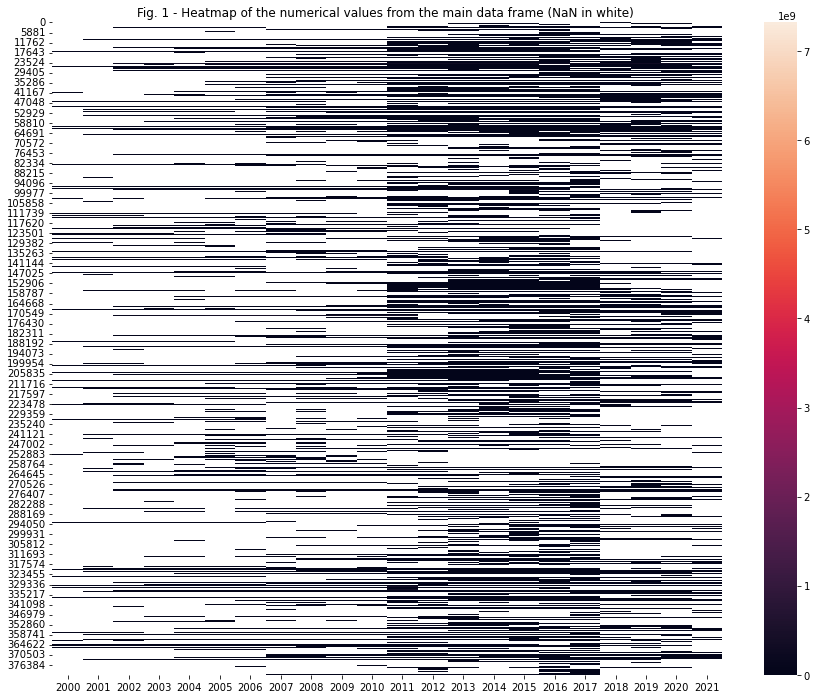

In [22]:
fig, ax = plt.subplots(figsize=(15, 12)) # Setting size of the plot
sns.heatmap(cuantitativeColumns, ax = ax)
ax.set_title('Fig. 1 - Heatmap of the numerical values from the main data frame (NaN in white) ');

-> Merging cuantitative and qualitative data frames

In [23]:
mainDF = pd.concat([categoricalDF, cuantitativeColumns], axis=1)
mainDF

freq pres species natvessr dest_use   unit        geo  2000  2001  \
0         A  CLA     BSS    TOTAL      HCN    EUR  EU27_2020   NaN   NaN   
1         A  CLA     BSS    TOTAL      HCN    EUR         NL   NaN   NaN   
2         A  CLA     BSS    TOTAL      HCN  EUR_T  EU27_2020   NaN   NaN   
3         A  CLA     BSS    TOTAL      HCN  EUR_T         NL   NaN   NaN   
4         A  CLA     BSS    TOTAL      HCN    TPW  EU27_2020   NaN   NaN   
...     ...  ...     ...      ...      ...    ...        ...   ...   ...   
382231    A  WHL     WIT    TOTAL      IND  EUR_T         NO   NaN   NaN   
382232    A  WHL     WIT    TOTAL      IND    TPW         NO   NaN   NaN   
382233    A  WHL     WIT    TOTAL    TOTAL    EUR         NO   NaN   NaN   
382234    A  WHL     WIT    TOTAL    TOTAL  EUR_T         NO   NaN   NaN   
382235    A  WHL     WIT    TOTAL    TOTAL    TPW         NO   NaN   NaN   

        2002  ...  2012  2013  2014  2015  2016  2017      2018      2019  \
0        NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN    19.396       NaN   
1        NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN    19.396       NaN   
2        NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN  9698.000       NaN   
3        NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN  9698.000       NaN   
4        NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN     0.002       NaN   
...      ...  ...   ...   ...   ...   ...   ...   ...       ...       ...   
382231   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN  327.4467   
382232   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN    0.4000   
382233   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN  130.9787   
382234   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN  327.4467   
382235   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN    0.4000   

        2020  2021  
0        NaN   NaN  
1        NaN   NaN  
2        NaN   NaN  
3        NaN   NaN  
4        NaN   NaN  
...      ...   ...  
382231   NaN   NaN  
382232   NaN   NaN  
382233   NaN   NaN  
382234   NaN   NaN  
382235   NaN   NaN  

[382236 rows x 29 columns]

Since the columns "freq" (frequency) and "natvessr" (Nationality of registration of vessel) have one unique value (A and TOTAL respecitvely), I dropped them:

In [24]:
print(mainDF['freq'].value_counts(),'\n\n',mainDF['natvessr'].value_counts())

A    382236
Name: freq, dtype: int64 

 TOTAL    382236
Name: natvessr, dtype: int64


In [25]:
mainDF.drop(['freq','natvessr'], axis=1, inplace = True) # inplace to save memory
mainDF

pres species dest_use   unit        geo  2000  2001  2002  2003  2004  \
0       CLA     BSS      HCN    EUR  EU27_2020   NaN   NaN   NaN   NaN   NaN   
1       CLA     BSS      HCN    EUR         NL   NaN   NaN   NaN   NaN   NaN   
2       CLA     BSS      HCN  EUR_T  EU27_2020   NaN   NaN   NaN   NaN   NaN   
3       CLA     BSS      HCN  EUR_T         NL   NaN   NaN   NaN   NaN   NaN   
4       CLA     BSS      HCN    TPW  EU27_2020   NaN   NaN   NaN   NaN   NaN   
...     ...     ...      ...    ...        ...   ...   ...   ...   ...   ...   
382231  WHL     WIT      IND  EUR_T         NO   NaN   NaN   NaN   NaN   NaN   
382232  WHL     WIT      IND    TPW         NO   NaN   NaN   NaN   NaN   NaN   
382233  WHL     WIT    TOTAL    EUR         NO   NaN   NaN   NaN   NaN   NaN   
382234  WHL     WIT    TOTAL  EUR_T         NO   NaN   NaN   NaN   NaN   NaN   
382235  WHL     WIT    TOTAL    TPW         NO   NaN   NaN   NaN   NaN   NaN   

        ...  2012  2013  2014  2015  2016  2017      2018      2019  2020  \
0       ...   NaN   NaN   NaN   NaN   NaN   NaN    19.396       NaN   NaN   
1       ...   NaN   NaN   NaN   NaN   NaN   NaN    19.396       NaN   NaN   
2       ...   NaN   NaN   NaN   NaN   NaN   NaN  9698.000       NaN   NaN   
3       ...   NaN   NaN   NaN   NaN   NaN   NaN  9698.000       NaN   NaN   
4       ...   NaN   NaN   NaN   NaN   NaN   NaN     0.002       NaN   NaN   
...     ...   ...   ...   ...   ...   ...   ...       ...       ...   ...   
382231  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN  327.4467   NaN   
382232  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN    0.4000   NaN   
382233  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN  130.9787   NaN   
382234  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN  327.4467   NaN   
382235  ...   NaN   NaN   NaN   NaN   NaN   NaN       NaN    0.4000   NaN   

        2021  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
382231   NaN  
382232   NaN  
382233   NaN  
382234   NaN  
382235   NaN  

[382236 rows x 27 columns]

Removing all rows from the UK, since it's out of the EU. Also de counts by different UE forms ('EU', 'EU27_2020' & 'EU28'):

In [26]:
# dropping all rows where geo is UK
mainDF.drop(mainDF[mainDF.geo == "UK"].index, inplace=True)
# dropping all EU rows
mainDF.drop(mainDF[mainDF.geo.str.contains("EU")].index, inplace=True)
# resetting index
mainDF.reset_index(inplace = True, drop = True)
mainDF

pres species dest_use   unit geo  2000  2001  2002  2003  2004  ...  \
0       CLA     BSS      HCN    EUR  NL   NaN   NaN   NaN   NaN   NaN  ...   
1       CLA     BSS      HCN  EUR_T  NL   NaN   NaN   NaN   NaN   NaN  ...   
2       CLA     BSS      HCN    TPW  NL   NaN   NaN   NaN   NaN   NaN  ...   
3       CLA     BSS    TOTAL    EUR  NL   NaN   NaN   NaN   NaN   NaN  ...   
4       CLA     BSS    TOTAL  EUR_T  NL   NaN   NaN   NaN   NaN   NaN  ...   
...     ...     ...      ...    ...  ..   ...   ...   ...   ...   ...  ...   
194701  WHL     WIT      IND  EUR_T  NO   NaN   NaN   NaN   NaN   NaN  ...   
194702  WHL     WIT      IND    TPW  NO   NaN   NaN   NaN   NaN   NaN  ...   
194703  WHL     WIT    TOTAL    EUR  NO   NaN   NaN   NaN   NaN   NaN  ...   
194704  WHL     WIT    TOTAL  EUR_T  NO   NaN   NaN   NaN   NaN   NaN  ...   
194705  WHL     WIT    TOTAL    TPW  NO   NaN   NaN   NaN   NaN   NaN  ...   

        2012  2013  2014  2015  2016  2017      2018      2019  2020  2021  
0        NaN   NaN   NaN   NaN   NaN   NaN    19.396       NaN   NaN   NaN  
1        NaN   NaN   NaN   NaN   NaN   NaN  9698.000       NaN   NaN   NaN  
2        NaN   NaN   NaN   NaN   NaN   NaN     0.002       NaN   NaN   NaN  
3        NaN   NaN   NaN   NaN   NaN   NaN    19.396       NaN   NaN   NaN  
4        NaN   NaN   NaN   NaN   NaN   NaN  9698.000       NaN   NaN   NaN  
...      ...   ...   ...   ...   ...   ...       ...       ...   ...   ...  
194701   NaN   NaN   NaN   NaN   NaN   NaN       NaN  327.4467   NaN   NaN  
194702   NaN   NaN   NaN   NaN   NaN   NaN       NaN    0.4000   NaN   NaN  
194703   NaN   NaN   NaN   NaN   NaN   NaN       NaN  130.9787   NaN   NaN  
194704   NaN   NaN   NaN   NaN   NaN   NaN       NaN  327.4467   NaN   NaN  
194705   NaN   NaN   NaN   NaN   NaN   NaN       NaN    0.4000   NaN   NaN  

[194706 rows x 27 columns]

### General check

In [27]:
mainDF.shape

(194706, 27)

In [28]:
mainDF.describe()

2000          2001          2002          2003          2004  \
count  1.936900e+04  2.452400e+04  3.807600e+04  3.756400e+04  4.591000e+04   
mean   1.704967e+06  1.955018e+06  7.510237e+06  8.319046e+06  7.048849e+06   
std    1.230406e+07  1.390989e+07  6.184356e+07  6.181721e+07  5.788541e+07   
min   -1.080196e+03 -5.726340e+03 -6.190809e+02 -3.374911e+04 -2.283159e+04   
25%    1.302000e+02  1.394000e+02  1.922853e+02  2.303678e+02  1.195000e+02   
50%    1.653246e+03  1.797187e+03  2.133801e+03  2.452000e+03  2.036891e+03   
75%    2.125329e+04  1.983127e+04  3.547945e+04  4.427849e+04  2.630919e+04   
max    3.765010e+08  4.082418e+08  1.958819e+09  1.873371e+09  1.847680e+09   

               2005          2006          2007          2008          2009  \
count  5.032800e+04  5.125800e+04  6.351900e+04  6.959800e+04  6.675500e+04   
mean   6.541424e+06  6.914756e+06  5.859069e+06  4.902938e+06  4.592531e+06   
std    5.669887e+07  5.965515e+07  5.324115e+07  4.856256e+07  4.671652e+07   
min   -2.923485e+04 -1.851069e+04  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.083000e+02  1.840000e+02  1.568519e+02  1.084500e+02  9.740000e+01   
50%    2.137888e+03  2.306000e+03  2.104000e+03  2.007460e+03  1.954500e+03   
75%    2.580090e+04  2.762157e+04  2.145737e+04  1.570574e+04  1.453857e+04   
max    1.513230e+09  1.679665e+09  1.671770e+09  1.916031e+09  1.793181e+09   

       ...          2012          2013          2014          2015  \
count  ...  7.915500e+04  8.755500e+04  8.628800e+04  9.550400e+04   
mean   ...  4.726961e+06  4.036553e+06  4.488687e+06  4.031740e+06   
std    ...  5.017540e+07  4.599541e+07  5.313435e+07  4.742797e+07   
min    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    ...  1.000000e+02  6.701000e+01  5.653900e+01  5.229600e+01   
50%    ...  1.980833e+03  1.834156e+03  1.822997e+03  1.668165e+03   
75%    ...  1.315089e+04  1.104655e+04  1.132809e+04  1.016520e+04   
max    ...  1.958458e+09  2.139882e+09  2.696236e+09  2.127582e+09   

               2016          2017          2018          2019          2020  \
count  9.670100e+04  9.459500e+04  9.446500e+04  9.975100e+04  9.786200e+04   
mean   4.272437e+06  3.947442e+06  3.938051e+06  3.708417e+06  3.508017e+06   
std    4.936938e+07  4.791099e+07  4.740154e+07  4.568790e+07  4.296176e+07   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.808800e+01  4.374000e+01  5.280000e+01  4.500025e+01  4.410000e+01   
50%    1.693870e+03  1.715000e+03  1.853519e+03  1.747870e+03  1.633520e+03   
75%    1.091867e+04  1.061070e+04  1.158000e+04  1.056754e+04  1.021680e+04   
max    2.113555e+09  2.152023e+09  2.135951e+09  2.194340e+09  2.190319e+09   

               2021  
count  8.920100e+04  
mean   2.633736e+06  
std    3.270279e+07  
min    0.000000e+00  
25%    3.695500e+01  
50%    1.738291e+03  
75%    1.044718e+04  
max    1.779608e+09  

[8 rows x 22 columns]

In [29]:
mainDF.describe(include = object)

pres species dest_use    unit     geo
count   194706  194706   194706  194706  194706
unique      41    1511        3       3      25
top      TOTAL     F00    TOTAL     TPW      ES
freq     37062    2479    93029   67889   49270

### IRISH DATA FRAME

In [30]:
irishDF = mainDF[mainDF['geo'] == 'IE']
irishDF

pres species dest_use   unit geo  2000  2001  2002  2003  2004  ...  \
44      CLA     CRE      HCN    EUR  IE   NaN   NaN   NaN   NaN   NaN  ...   
53      CLA     CRE      HCN  EUR_T  IE   NaN   NaN   NaN   NaN   NaN  ...   
62      CLA     CRE      HCN    TPW  IE   NaN   NaN   NaN   NaN   NaN  ...   
74      CLA     CRE    TOTAL    EUR  IE   NaN   NaN   NaN   NaN   NaN  ...   
83      CLA     CRE    TOTAL  EUR_T  IE   NaN   NaN   NaN   NaN   NaN  ...   
...     ...     ...      ...    ...  ..   ...   ...   ...   ...   ...  ...   
194196  UNK     WRF    TOTAL  EUR_T  IE   NaN   NaN   NaN   NaN   NaN  ...   
194197  UNK     WRF    TOTAL    TPW  IE   NaN   NaN   NaN   NaN   NaN  ...   
194204  UNK     YRS    TOTAL    EUR  IE   NaN   NaN   NaN   NaN   NaN  ...   
194205  UNK     YRS    TOTAL  EUR_T  IE   NaN   NaN   NaN   NaN   NaN  ...   
194206  UNK     YRS    TOTAL    TPW  IE   NaN   NaN   NaN   NaN   NaN  ...   

            2012  2013  2014       2015       2016       2017        2018  \
44           NaN   NaN   NaN  2279.2000  4625.9132  8006.8901  22849.4278   
53           NaN   NaN   NaN   468.9712   627.6680   600.4417    756.1166   
62           NaN   NaN   NaN     4.8600     7.3700    13.3350     30.2195   
74           NaN   NaN   NaN  2279.2000  4625.9132  8006.8901  22849.4278   
83           NaN   NaN   NaN   468.9712   627.6680   600.4417    756.1166   
...          ...   ...   ...        ...        ...        ...         ...   
194196  2000.000   NaN   NaN        NaN  2000.0000  2000.0000         NaN   
194197     1.099   NaN   NaN        NaN     0.1620     0.3730         NaN   
194204       NaN   NaN   NaN        NaN        NaN        NaN         NaN   
194205       NaN   NaN   NaN        NaN        NaN        NaN         NaN   
194206       NaN   NaN   NaN        NaN        NaN        NaN         NaN   

              2019  2020         2021  
44      17183.6710   NaN  114224.3198  
53        853.0289   NaN    4785.1065  
62         20.1443   NaN      23.8708  
74      17183.6710   NaN          NaN  
83        853.0289   NaN          NaN  
...            ...   ...          ...  
194196         NaN   NaN          NaN  
194197         NaN   NaN          NaN  
194204         NaN   NaN          NaN  
194205         NaN   NaN          NaN  
194206         NaN   NaN          NaN  

[10147 rows x 27 columns]

Reindexing the Irish data frame and dropping the column 'geo'

In [31]:
# inplace to save memory and dropping the old index columns which would remain otherwise
irishDF.reset_index(inplace = True, drop = True)
irishDF = irishDF.drop('geo', axis=1)
irishDF

pres species dest_use   unit  2000  2001  2002  2003  2004  2005  ...  \
0      CLA     CRE      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1      CLA     CRE      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2      CLA     CRE      HCN    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3      CLA     CRE    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4      CLA     CRE    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...    ...     ...      ...    ...   ...   ...   ...   ...   ...   ...  ...   
10142  UNK     WRF    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
10143  UNK     WRF    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
10144  UNK     YRS    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
10145  UNK     YRS    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
10146  UNK     YRS    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   

           2012  2013  2014       2015       2016       2017        2018  \
0           NaN   NaN   NaN  2279.2000  4625.9132  8006.8901  22849.4278   
1           NaN   NaN   NaN   468.9712   627.6680   600.4417    756.1166   
2           NaN   NaN   NaN     4.8600     7.3700    13.3350     30.2195   
3           NaN   NaN   NaN  2279.2000  4625.9132  8006.8901  22849.4278   
4           NaN   NaN   NaN   468.9712   627.6680   600.4417    756.1166   
...         ...   ...   ...        ...        ...        ...         ...   
10142  2000.000   NaN   NaN        NaN  2000.0000  2000.0000         NaN   
10143     1.099   NaN   NaN        NaN     0.1620     0.3730         NaN   
10144       NaN   NaN   NaN        NaN        NaN        NaN         NaN   
10145       NaN   NaN   NaN        NaN        NaN        NaN         NaN   
10146       NaN   NaN   NaN        NaN        NaN        NaN         NaN   

             2019  2020         2021  
0      17183.6710   NaN  114224.3198  
1        853.0289   NaN    4785.1065  
2         20.1443   NaN      23.8708  
3      17183.6710   NaN          NaN  
4        853.0289   NaN          NaN  
...           ...   ...          ...  
10142         NaN   NaN          NaN  
10143         NaN   NaN          NaN  
10144         NaN   NaN          NaN  
10145         NaN   NaN          NaN  
10146         NaN   NaN          NaN  

[10147 rows x 26 columns]

In [32]:
irishDF.describe(include = object)

pres species dest_use   unit
count   10147   10147    10147  10147
unique     25     327        3      3
top     TOTAL     F01    TOTAL    TPW
freq     2062     152     5120   3439

In [33]:
irishDF.iloc[:,4:].apply(pd.DataFrame.describe, axis=1)

count          mean           std        min          25%          50%  \
0        6.0  28194.903650  42861.541496  2279.2000  5471.157425  12595.28055   
1        6.0   1348.555483   1688.753080   468.9712   607.248275    691.89230   
2        6.0     16.633267      9.844709     4.8600     8.861250     16.73965   
3        5.0  10989.020420   8721.900101  2279.2000  4625.913200   8006.89010   
4        5.0    661.245280    147.965668   468.9712   600.441700    627.66800   
...      ...           ...           ...        ...          ...          ...   
10142    3.0   2000.000000      0.000000  2000.0000  2000.000000   2000.00000   
10143    3.0      0.544667      0.491522     0.1620     0.267500      0.37300   
10144    0.0           NaN           NaN        NaN          NaN          NaN   
10145    0.0           NaN           NaN        NaN          NaN          NaN   
10146    0.0           NaN           NaN        NaN          NaN          NaN   

                75%          max  
0      21432.988600  114224.3198  
1        828.800825    4785.1065  
2         22.939175      30.2195  
3      17183.671000   22849.4278  
4        756.116600     853.0289  
...             ...          ...  
10142   2000.000000    2000.0000  
10143      0.736000       1.0990  
10144           NaN          NaN  
10145           NaN          NaN  
10146           NaN          NaN  

[10147 rows x 8 columns]

Checking NaN's:

In [34]:
# per column
irishDF.iloc[:,4:].isnull().sum()

2000    7254
2001    8052
2002    7115
2003    8139
2004    8133
2005    8237
2006    8269
2007    8179
2008    8281
2009    8083
2010    8013
2011    8089
2012    7021
2013    8113
2014    8167
2015    6301
2016    6319
2017    6775
2018    9244
2019    8683
2020    9506
2021    9280
dtype: int64

In [35]:
#total
irishDF.isnull().sum().sum()

175253

Checking the proportion of NaN values (78.5% of the numerical values are missing):

In [36]:
(irishDF.isnull().sum().sum() * 100) / (len(irishDF) * 22)

78.50641031384109

In [37]:
irishDF.head(50)

pres species dest_use   unit  2000  2001  2002  2003  2004  2005  ...  \
0   CLA     CRE      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1   CLA     CRE      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2   CLA     CRE      HCN    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3   CLA     CRE    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4   CLA     CRE    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5   CLA     CRE    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6   CLA     F00      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
7   CLA     F00      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
8   CLA     F00      HCN    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
9   CLA     F00    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
10  CLA     F00    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
11  CLA     F00    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
12  CLA     F01      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
13  CLA     F01      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
14  CLA     F01      HCN    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
15  CLA     F01    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
16  CLA     F01    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
17  CLA     F01    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
18  CLA     F04      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
19  CLA     F04      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
20  CLA     F04      HCN    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
21  CLA     F04    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
22  CLA     F04    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
23  CLA     F04    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
24  CLA     F08      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
25  CLA     F08      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
26  CLA     F08      HCN    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
27  CLA     F08    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
28  CLA     F08    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
29  CLA     F08    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
30  CLA     F40      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
31  CLA     F40      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
32  CLA     F40      HCN    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
33  CLA     F40    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
34  CLA     F40    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
35  CLA     F40    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
36  CLA     F42      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
37  CLA     F42      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
38  CLA     F42      HCN    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
39  CLA     F42    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
40  CLA     F42    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
41  CLA     F42    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
42  CLA     KEF      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
43  CLA     KEF      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
44  CLA     KEF      HCN    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
45  CLA     KEF    TOTAL    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
46  CLA     KEF    TOTAL  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   
47  CLA     KEF    TOTAL    TPW   NaN   NaN   NaN   NaN   NaN   NaN  ...   
48  CLA     SCR      HCN    EUR   NaN   NaN   NaN   NaN   NaN   NaN  ...   
49  CLA     SCR      HCN  EUR_T   NaN   NaN   NaN   NaN   NaN   NaN  ...   

    2012  2013  2014        2015       2016       2017        2018  \
0    NaN   NaN   NaN   2279.2000  4625.9132  8006.8901  

Heatmap to visualize Nan values (in white)

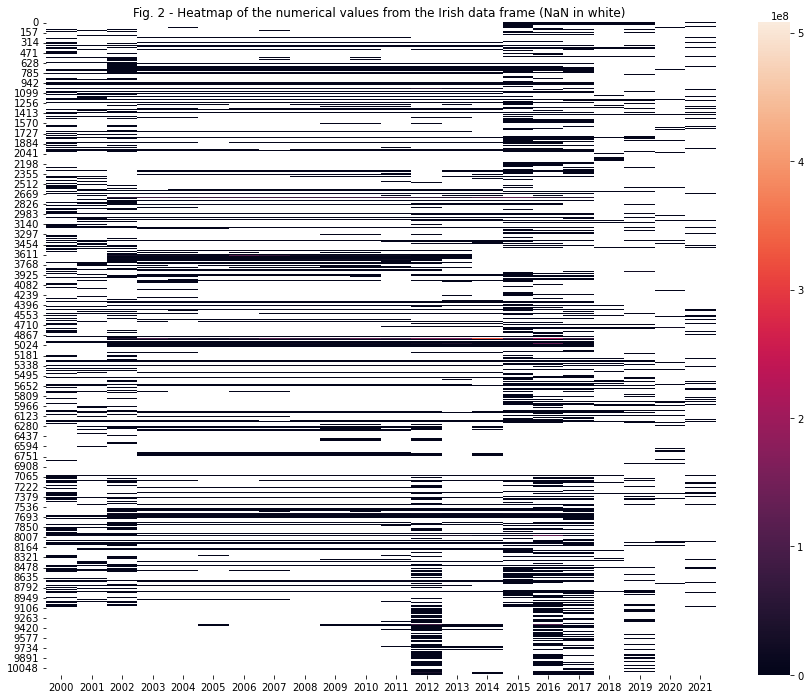

In [38]:
fig, ax = plt.subplots(figsize=(15, 12)) # Setting size of the plot
sns.heatmap(irishDF[['2000','2001','2002','2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']], ax = ax) # Selecting the numerical columns only
ax.set_title('Fig. 2 - Heatmap of the numerical values from the Irish data frame (NaN in white) ');

Checking freshwater fish and aquatic plants landing data

In [39]:
# quering all rows from the species entered, then query again to get totals of presentation forms
irishDF.query('species == "F02" | species == "F10" | species == "F41" | species == "F51" | species == "F90"').query('pres == "TOTAL"')

pres species dest_use   unit  2000  2001      2002  2003  2004  2005  \
7577  TOTAL     F02      HCN    EUR   NaN   NaN   253.948   NaN   NaN   NaN   
7578  TOTAL     F02      HCN  EUR_T   NaN   NaN  1269.740   NaN   NaN   NaN   
7579  TOTAL     F02      HCN    TPW   0.1   1.1     0.200   NaN   NaN   NaN   
7580  TOTAL     F02    TOTAL    EUR   NaN   NaN   253.948   NaN   NaN   NaN   
7581  TOTAL     F02    TOTAL  EUR_T   NaN   NaN  1269.740   NaN   NaN   NaN   
7582  TOTAL     F02    TOTAL    TPW   0.1   1.1     0.200   NaN   NaN   NaN   

      ...  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  
7577  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
7578  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
7579  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
7580  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
7581  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
7582  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[6 rows x 26 columns]

In [40]:
# Checking the numerical values of the row with totals
irishDF.iloc[7582,4:]

2000    0.1
2001    1.1
2002    0.2
2003    NaN
2004    NaN
2005    NaN
2006    NaN
2007    NaN
2008    NaN
2009    NaN
2010    NaN
2011    NaN
2012    NaN
2013    NaN
2014    NaN
2015    NaN
2016    NaN
2017    NaN
2018    NaN
2019    NaN
2020    NaN
2021    NaN
Name: 7582, dtype: object

Plotting the total tones of aquatic animal landing per year

In [41]:
# row in question
irishDF.iloc[7576]

pres              TOTAL
species             F01
dest_use          TOTAL
unit                TPW
2000           202908.5
2001           254302.2
2002           173982.0
2003           299193.0
2004           260449.9
2005           198958.3
2006           220211.8
2007           244295.7
2008           209668.4
2009           247050.4
2010          247841.15
2011          180970.09
2012         340975.871
2013        229092.8118
2014        270835.1244
2015        243580.8393
2016        263025.0901
2017        263760.6687
2018                NaN
2019                NaN
2020                NaN
2021                NaN
Name: 7576, dtype: object

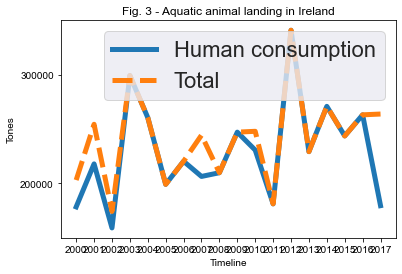

In [42]:
# each plot is specified by its corresponding row (total aquatic animals, and total aquatic animal for human consumption)
ax = sns.lineplot(data=[irishDF.loc[7576][4:],irishDF.loc[7570][4:]], linewidth = 5).set(
    xlabel ="Timeline", 
    ylabel = "Tones", 
    title = 'Fig. 3 - Aquatic animal landing in Ireland')

# setting up size and legend
sns.set(font_scale=2, rc={'figure.figsize':(30,10)}) # tick label font size and chart size
plt.legend(labels=['Human consumption', 'Total']);

Showing main central dispersion measures

In [43]:
print('mean =',"{:.1f}".format(irishDF.iloc[7576][4:].mean()),'\nstand dev = ',"{:.1f}".format(irishDF.iloc[7576][4:].std()),'\nmedian =',"{:.1f}".format(irishDF.iloc[7576][4:].median()))


mean = 241727.9 
stand dev =  41152.9 
median = 245673.0


General presentation forms

In [44]:
# Selecting total fishery products (F00) and the main presentations forms (fresh, salting, smoked, dried, roes, whole and unknown)
irishDF.query('species == "F00" & dest_use == "TOTAL" & unit == "TPW"').query('pres == "FRE" | pres == "FRO" | pres == "SAL" | pres == "SMO" | pres == "COK" | pres == "DRI" | pres == "CLA" | pres == "ROE" | pres == "WHL"| pres == "UNK"') #.iloc[:,4:].apply(pd.DataFrame.describe, axis=1).sort_values('mean',ascending=False)

pres species dest_use unit      2000      2001      2002      2003  \
11    CLA     F00    TOTAL  TPW       NaN       NaN       NaN       NaN   
547   FRE     F00    TOTAL  TPW  202902.9  254197.7  173981.9  299119.2   
6278  FRO     F00    TOTAL  TPW       NaN     104.5       0.1      73.8   
6824  ROE     F00    TOTAL  TPW       5.6       NaN       NaN       NaN   
6875  SAL     F00    TOTAL  TPW       NaN       NaN       NaN       NaN   
9345  UNK     F00    TOTAL  TPW       NaN       NaN       NaN       NaN   

          2004      2005  ...        2012         2013         2014  \
11         NaN       NaN  ...         NaN          NaN          NaN   
547   260428.4  198843.9  ...  233190.173  228083.5546  268699.6007   
6278      21.5      73.4  ...       7.583          NaN       1.1250   
6824       NaN       NaN  ...         NaN          NaN          NaN   
6875       NaN       NaN  ...         NaN          NaN          NaN   
9345       NaN      41.0  ...  107778.115    1009.2572    2134.3987   

             2015         2016         2017     2018      2019  2020  2021  
11        38.9970       7.3700      13.3350  30.2195  107.9868   NaN   NaN  
547   243541.8423  196191.3449  179292.6022      NaN       NaN   NaN   NaN  
6278          NaN          NaN          NaN      NaN       NaN   NaN   NaN  
6824          NaN          NaN          NaN      NaN       NaN   NaN   NaN  
6875          NaN          NaN          NaN      NaN       NaN   NaN   NaN  
9345          NaN   66826.3752   84454.7315      NaN       NaN   NaN   NaN  

[6 rows x 26 columns]

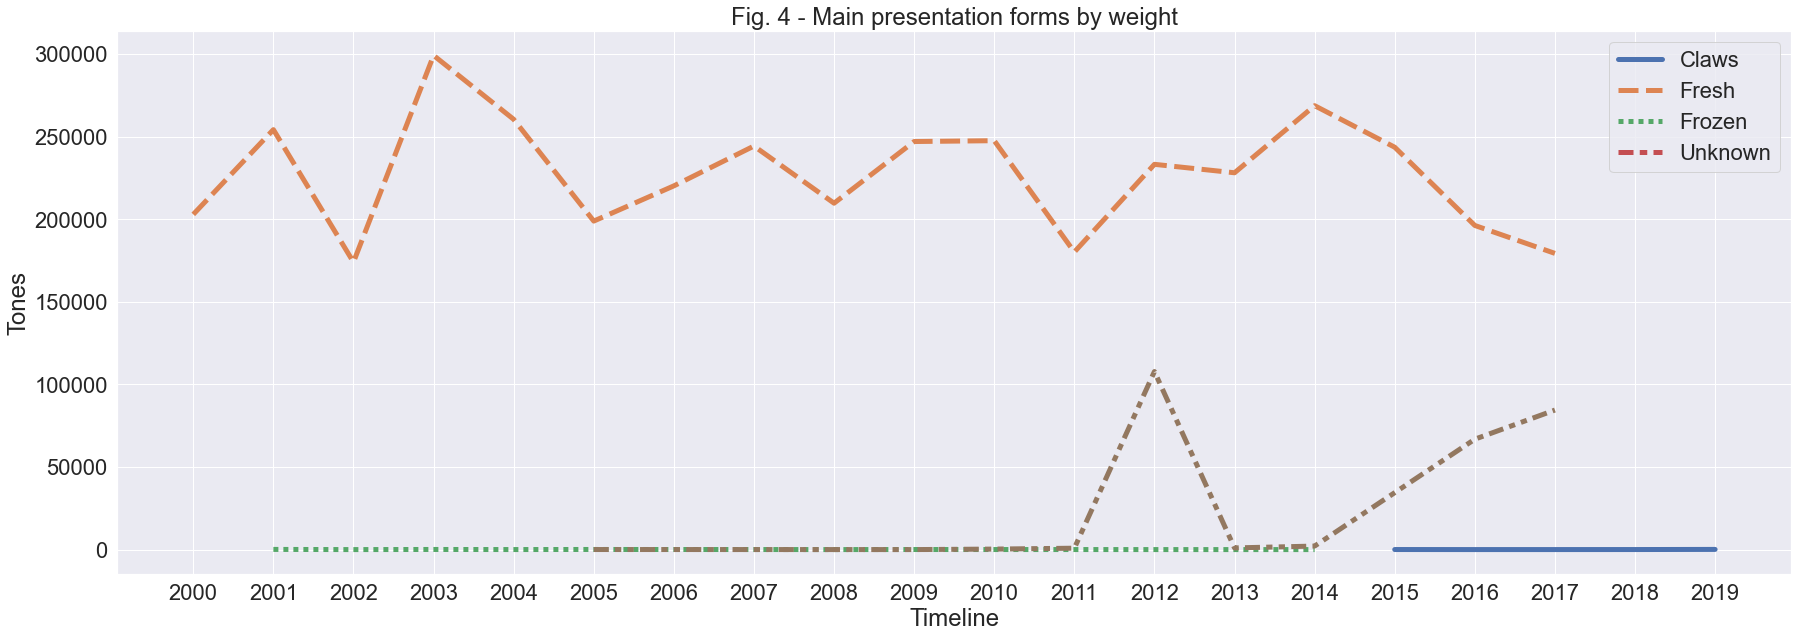

In [45]:
# each plot is specified by its corresponding row (total aquatic animals, and total aquatic animal for human consumption)
ax = sns.lineplot(data=[irishDF.loc[11][4:],irishDF.loc[547][4:],irishDF.loc[6278][4:],irishDF.loc[6824][4:],irishDF.loc[6875][4:],irishDF.loc[9345][4:]],linewidth = 5).set(
    xlabel ="Timeline", 
    ylabel = "Tones", 
    title = 'Fig. 4 - Main presentation forms by weight')

# setting up size and legend
sns.set(font_scale=2, rc={'figure.figsize':(30,15)}) # tick label font size and chart size
plt.legend(labels=['Claws', 'Fresh', 'Frozen', 'Unknown']);

In [46]:
# Selecting rows containing FRE_ in the presentation column, and then quering the other paramters with total 
irishDF[irishDF['pres'].str.contains('FRE_')].query('species == "F00" & dest_use == "TOTAL" & unit == "TPW"')

pres species dest_use unit      2000      2001      2002      2003  \
2052  FRE_ALI     F00    TOTAL  TPW       NaN       NaN       NaN       NaN   
2175  FRE_FIL     F00    TOTAL  TPW       NaN       NaN       NaN       NaN   
2305  FRE_GUH     F00    TOTAL  TPW      18.8      13.9       NaN      20.2   
2715  FRE_GUT     F00    TOTAL  TPW   37424.6   38055.7   25882.0   31785.1   
3588  FRE_NSP     F00    TOTAL  TPW   19286.0   48757.3   25573.4   48562.7   
3933  FRE_OTH     F00    TOTAL  TPW      10.8     180.1       0.8      10.9   
4337  FRE_TAL     F00    TOTAL  TPW    1213.6     883.4     690.1    1146.4   
4890  FRE_WHL     F00    TOTAL  TPW  144949.1  166307.3  121835.6  217593.9   

          2004      2005  ...        2012         2013         2014  \
2052       NaN       NaN  ...         NaN          NaN          NaN   
2175       NaN       NaN  ...         NaN          NaN          NaN   
2305       7.0       6.5  ...         NaN       0.6750       9.8330   
2715   23981.8   26686.6  ...   20888.163   21099.5582   33165.9107   
3588   48577.4   14941.2  ...    1887.493      58.5700          NaN   
3933     154.0       5.2  ...       2.343       5.7115      11.3745   
4337    1051.3     946.1  ...    1902.176    1281.7111    1309.3175   
4890  186656.9  156258.3  ...  208509.998  205637.3288  234203.1650   

             2015         2016         2017  2018  2019  2020  2021  
2052          NaN          NaN          NaN   NaN   NaN   NaN   NaN  
2175      14.5925       1.1700       0.0375   NaN   NaN   NaN   NaN  
2305      77.7272      63.2928      14.2672   NaN   NaN   NaN   NaN  
2715   40796.0440   22832.9968   16346.2341   NaN   NaN   NaN   NaN  
3588          NaN          NaN          NaN   NaN   NaN   NaN   NaN  
3933    3016.3028     341.9599     183.2628   NaN   NaN   NaN   NaN  
4337    3748.1375    2866.9137    2244.1328   NaN   NaN   NaN   NaN  
4890  195889.0384  170085.0116  160504.6679   NaN   NaN   NaN   NaN  

[8 rows x 26 columns]

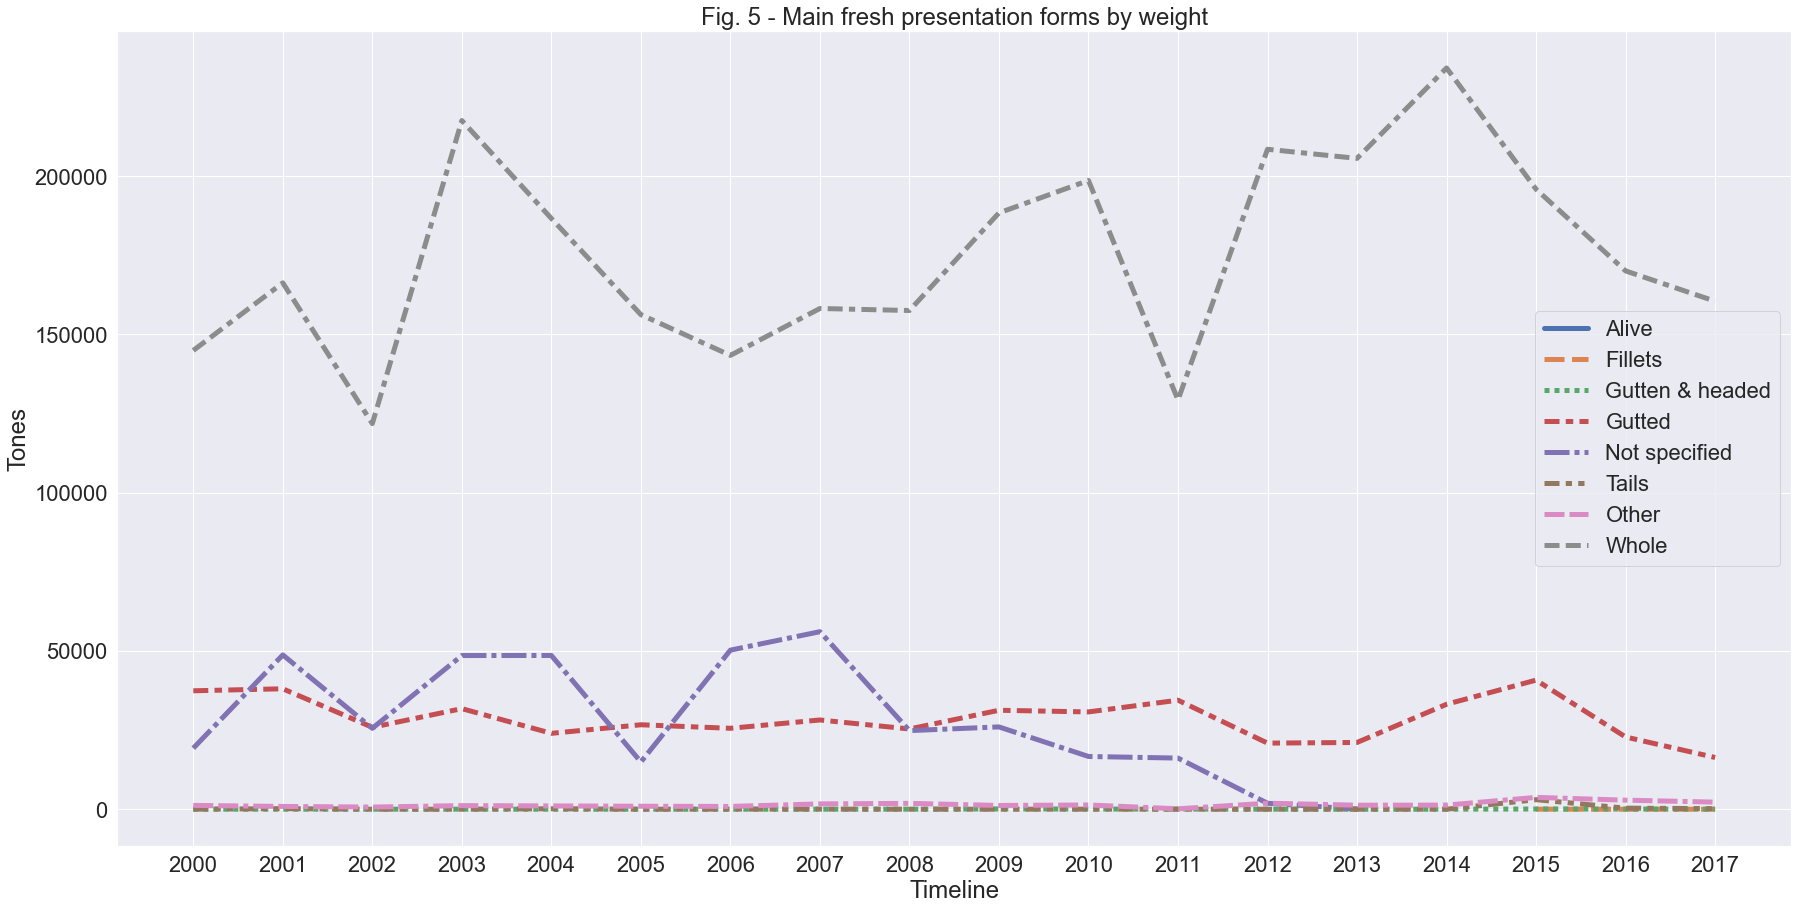

In [47]:
# each plot is specified by its corresponding row (total aquatic animals, and total aquatic animal for human consumption)
ax = sns.lineplot(data=[irishDF.loc[2052][4:],irishDF.loc[2175][4:],irishDF.loc[2305][4:],irishDF.loc[2715][4:],irishDF.loc[3588][4:],irishDF.loc[3933][4:],irishDF.loc[4337][4:],irishDF.loc[4890][4:]],linewidth = 5).set(
    xlabel ="Timeline", 
    ylabel = "Tones", 
    title = 'Fig. 5 - Main fresh presentation forms by weight')

# setting up size and legend
sns.set(font_scale=2, rc={'figure.figsize':(30,15)}) # tick label font size and chart size
plt.legend(labels=['Alive', 'Fillets', 'Gutten & headed', 'Gutted', 'Not specified', 'Tails', 'Other', 'Whole']);

Checking the most expensive species per weight unit

In [48]:
# Calculating the means of the selected rows (rather than columns, reason why I applied the describe to axis X), then sorted the rows by mean in descending order, and limited the output up to the 12th. Stored indexes in a list  
expensiveIrishIndexList = irishDF.query('dest_use == "TOTAL" & unit == "EUR_T"').iloc[:,4:].apply(pd.DataFrame.describe, axis=1).sort_values('mean',ascending=False).head(11).index.tolist()
expensiveIrishIndexList

[8958, 6115, 1893, 2153, 507, 4850, 7527, 9017, 6166, 1952, 4745]

In [49]:
irishDF.iloc[8958, 4:].mean()

41345.7093

In [50]:
# printing the species, result formatted to show one single decimal
for i in expensiveIrishIndexList:
    print(irishDF['species'].loc[i],' - ',"{:.1f}".format(irishDF.iloc[i, 4:].mean()))

TBR  -  41345.7
TBR  -  41345.7
TBR  -  41345.7
SLO  -  34793.1
ENX  -  33773.1
ENX  -  33773.1
ENX  -  33773.1
USI  -  26785.3
USI  -  26785.3
USI  -  26785.3
CRW  -  25945.6


### DF with TOTALS per country

In [51]:
mapChart = mainDF.query('pres == "TOTAL" & species == "F00" & dest_use == "TOTAL" & unit == "TPW"').iloc[:,4:]
mapChart = mapChart.reset_index(drop=True) # reindexing df
mapChart

geo       2000       2001        2002       2003        2004        2005  \
0   BE    17987.3    18357.4    19874.40    20278.8    21243.30    19601.00   
1   BG        NaN        NaN         NaN        NaN         NaN     3408.00   
2   CY        NaN        NaN         NaN        NaN      773.80     1329.10   
3   DE    86560.9    84530.9    81781.30   102478.5   134199.50   139919.20   
4   DK  1077140.0   910821.8   851962.60   980281.6   977369.40  1005621.60   
5   EE        NaN        NaN         NaN        NaN         NaN    69405.70   
6   EL    90381.2    86565.9    91891.46    89632.0    91133.98    90445.09   
7   ES   983806.1   962823.0   918245.10   876467.7   700706.10   703248.70   
8   FI    96417.7    93499.0    96710.50    76210.3    84560.60    84098.30   
9   FR   371264.3   366121.4   374779.30   334546.8   321292.80   294990.10   
10  HR        NaN        NaN         NaN        NaN         NaN         NaN   
11  IE   202908.5   254302.2   173982.00   299193.0   260449.90   198958.30   
12  IS  1947010.3  1953473.1  2110783.50  1984055.0  1747508.40  1674945.60   
13  IT   295096.0   308488.0   253802.00   265122.0   260594.00   281987.00   
14  LT        NaN        NaN         NaN        NaN         NaN     6874.60   
15  LV        NaN        NaN         NaN        NaN         NaN    90598.40   
16  MT        NaN        NaN         NaN     1068.2     1066.90     1332.50   
17  NL   508971.2   531698.0   478159.00   533082.7   578886.80   621101.10   
18  NO  2561152.8  2535941.1  2486795.30  2145732.2  2132103.80  1996259.90   
19  PL        NaN        NaN         NaN        NaN         NaN    81688.00   
20  PT   163948.6   167671.4   173919.10   142690.4   164879.40   105860.20   
21  RO        NaN        NaN         NaN        NaN         NaN         NaN   
22  SE   307692.8   289026.7   257399.60   236441.2   244814.40   268799.40   
23  SI        NaN        NaN     1456.00     1086.2      808.10     1010.70   
24  TR        NaN        NaN         NaN        NaN         NaN         NaN   

          2006         2007         2008  ...         2012          2013  \
0     18257.80    19120.000    17349.000  ...    17646.000  1.639540e+04   
1      4388.40     7831.200     7651.900  ...     8150.400  9.533892e+03   
2      1897.50     2019.100     1867.700  ...     1297.000  1.169200e+03   
3    130174.90   113137.600   101344.200  ...   107054.600  9.867780e+04   
4    852890.30  1049492.900   974362.700  ...   612303.100  8.410728e+05   
5     70623.70    75824.139    81825.029  ...    61027.662  6.211730e+04   
6     96694.25    93639.340    83820.990  ...    60725.480  6.363800e+04   
7    777542.60   836770.500   891284.400  ...   732943.940  8.682778e+05   
8     91050.00    92793.300    90685.500  ...   102794.600  1.097769e+05   
9    325910.00   310958.100   285861.400  ...   365170.595  3.742880e+05   
10         NaN          NaN          NaN  ...    62349.210  7.470482e+04   
11   220211.80   244295.700   209668.400  ...   340975.871  2.290928e+05   
12  1305992.20  1364575.800  1253148.000  ...  1424938.500  1.271249e+06   
13   299266.00   276743.100   227159.600  ...   195838.600  1.729068e+05   
14     5229.10    15292.700     7531.900  ...     3466.955  2.531786e+03   
15    81003.20    80998.200    85767.200  ...    59843.850  6.535733e+04   
16     1290.70     1252.400     1297.600  ...          NaN           NaN   
17   781360.50   882233.000   464259.700  ...   373392.400  3.032461e+05   
18  1931808.20  2029219.000  2084867.100  ...  1813340.800  1.710271e+06   
19    79911.80    79054.100    65789.900  ...   105420.042  1.024587e+05   
20   170858.20   181402.600   185208.800  ...   149789.200  1.540880e+05   
21      615.20      518.000      443.900  ...      810.700  1.617401e+03   
22   270168.60   242222.700   226981.500  ...   108744.800  1.264629e+05   
23      934.90      917.000      694.600  ...      329.300  2.378000e+02   
24         NaN          NaN          NaN  ...   

In [52]:
# Proportion of NaN's
mapChart.isnull().sum().sum()*100/(mapChart.iloc[:,1:].size)

16.181818181818183

The countries have an alpha-2 ISO code but choropleth takes alpha-3 values. On the other hand Greece has the geo "EL" assigned, which is not ISO:

In [53]:
np.sort(mainDF['geo'].unique())

array(['BE', 'BG', 'CY', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'HR',
       'IE', 'IS', 'IT', 'LT', 'LV', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO',
       'SE', 'SI', 'TR'], dtype=object)

In [54]:
# Switching 'EL' for 'GR'
mapChart['geo'] = mapChart['geo'].replace({'EL':'GR'})
# Switching alpha-2 for alpha-3 codes with pycountry-convert package
mapChart['geo'] = mapChart.geo.apply(lambda x: country_name_to_country_alpha3(country_alpha2_to_country_name(x)))
mapChart['geo']

0     BEL
1     BGR
2     CYP
3     DEU
4     DNK
5     EST
6     GRC
7     ESP
8     FIN
9     FRA
10    HRV
11    IRL
12    ISL
13    ITA
14    LTU
15    LVA
16    MLT
17    NLD
18    NOR
19    POL
20    PRT
21    ROU
22    SWE
23    SVN
24    TUR
Name: geo, dtype: object

Counting the number of repeated values. From the total number of cells in the data frame, deducting all the NaN's and also the unique values per row:

In [55]:
nullCount = mapChart.isnull().sum().sum()

# number of numerical unique values per row
uniqueCount = mapChart.iloc[:,1:].apply(pd.Series.nunique, axis=1, dropna = True).sum()

mapChart.size - uniqueCount - nullCount

25

In [56]:
# number of NaN's per country (row)
mapChart.isnull().sum(axis=1)

0      0
1      5
2      4
3      0
4      3
5      5
6      3
7      0
8      0
9      0
10    11
11     4
12     1
13     0
14     5
15     5
16    13
17     0
18     1
19     5
20     0
21     6
22     0
23     2
24    16
dtype: int64

In [57]:
mapChart['geo']

0     BEL
1     BGR
2     CYP
3     DEU
4     DNK
5     EST
6     GRC
7     ESP
8     FIN
9     FRA
10    HRV
11    IRL
12    ISL
13    ITA
14    LTU
15    LVA
16    MLT
17    NLD
18    NOR
19    POL
20    PRT
21    ROU
22    SWE
23    SVN
24    TUR
Name: geo, dtype: object

In [58]:
# checking descriptive stats per row
mapChart.iloc[:,1:].apply(pd.DataFrame.describe, axis=1)

count          mean            std           min           25%  \
0    22.0  1.732753e+04    2372.849869  1.225580e+04  1.619545e+04   
1    17.0  7.960580e+03    1795.591339  3.408000e+03  7.651900e+03   
2    18.0  1.377258e+03     307.882721  7.738000e+02  1.208161e+03   
3    22.0  1.047739e+05   22959.447745  6.410026e+04  8.673875e+04   
4    19.0  9.297020e+05  136486.314610  6.123031e+05  8.529929e+05   
5    17.0  7.093594e+04    9348.062803  5.964835e+04  6.234024e+04   
6    19.0  7.839664e+04   13461.705071  5.869190e+04  6.403470e+04   
7    22.0  8.192576e+05  105325.431712  7.002376e+05  7.177435e+05   
8    22.0  9.431751e+04   13666.350137  7.621030e+04  8.443993e+04   
9    22.0  3.193813e+05   42428.360767  2.142133e+05  2.922264e+05   
10   11.0  6.947994e+04    5539.767941  6.115392e+04  6.600803e+04   
11   18.0  2.417279e+05   41152.941282  1.739820e+05  2.123042e+05   
12   21.0  1.379405e+06  374348.912341  9.024219e+05  1.077313e+06   
13   22.0  2.245034e+05   50365.302295  1.367714e+05  1.917761e+05   
14   17.0  4.574932e+03    3670.802496  1.004253e+03  2.026047e+03   
15   17.0  7.056130e+04    9333.541155  5.931682e+04  6.535733e+04   
16    9.0  1.409432e+03     313.317930  1.066900e+03  1.252400e+03   
17   22.0  5.019587e+05  138166.773269  2.845652e+05  4.268956e+05   
18   21.0  2.063101e+06  247665.230715  1.710271e+06  1.898295e+06   
19   17.0  9.838819e+04   17583.770340  6.578990e+04  8.168800e+04   
20   22.0  1.519701e+05   23602.595937  1.058602e+05  1.310508e+05   
21   16.0  3.209894e+03    3178.309161  2.308460e+02  5.323910e+02   
22   22.0  1.734642e+05   87147.091195  3.639376e+04  9.353953e+04   
23   20.0  5.532155e+02     415.330623  1.064467e+02  1.546475e+02   
24    6.0  3.273072e+05   53917.363707  2.838556e+05  2.963782e+05   

             50%           75%           max  
0   1.749750e+04  1.900785e+04  2.124330e+04  
1   8.545937e+03  8.919035e+03  1.026810e+04  
2   1.303100e+03  1.480250e+03  2.019100e+03  
3   1.041604e+05  1.163026e+05  1.628480e+05  
4   9.743627e+05  1.020567e+06  1.148943e+06  
5   6.940570e+04  7.837002e+04  8.705941e+04  
6   8.223270e+04  9.041314e+04  9.669425e+04  
7   8.181848e+05  8.744202e+05  1.079019e+06  
8   9.251993e+04  9.799948e+04  1.337703e+05  
9   3.236014e+05  3.595426e+05  3.747793e+05  
10  6.970074e+04  7.262333e+04  7.942169e+04  
11  2.456730e+05  2.623813e+05  3.409759e+05  
12  1.271249e+06  1.674946e+06  2.110784e+06  
13  2.199450e+05  2.639900e+05  3.084880e+05  
14  2.650857e+03  6.390700e+03  1.529270e+04  
15  6.728469e+04  7.438407e+04  9.059840e+04  
16  1.297600e+03  1.606500e+03  1.924700e+03  
17  4.840446e+05  5.430598e+05  8.822330e+05  
18  1.996260e+06  2.145732e+06  2.561153e+06  
19  1.039379e+05  1.128673e+05  1.259079e+05  
20  1.519386e+05  1.700615e+05  1.852088e+05  
21  1.908285e+03  5.419252e+03  9.553180e+03  
22  1.936840e+05  2.441665e+05  3.076928e+05  
23  5.119500e+02  8.795000e+02  1.456000e+03  
24  3.112021e+05  3.288279e+05  4.314431e+05

Checking if the distribution from each sample come from a normal distribution with Shapiro-Wilk test

In [59]:
# Looping through the df to print the non-normal distributions (dropping NaN values)
nonNormalDist = []
for index, row in mapChart.iterrows():
    if shapiro(mapChart.iloc[index,1:].dropna()).pvalue < 0.05:
        print(mapChart.iloc[index,0],' - ', shapiro(mapChart.iloc[index,1:].dropna()).pvalue)
        nonNormalDist.append(index)

BGR  -  0.01007260661572218
GRC  -  0.017165888100862503
ISL  -  0.03127758204936981
LTU  -  0.003047722624614835
ROU  -  0.01031850092113018
SWE  -  0.033335182815790176
SVN  -  0.013608482666313648
TUR  -  0.044375043362379074


Their probability plots do not show they fit to the line

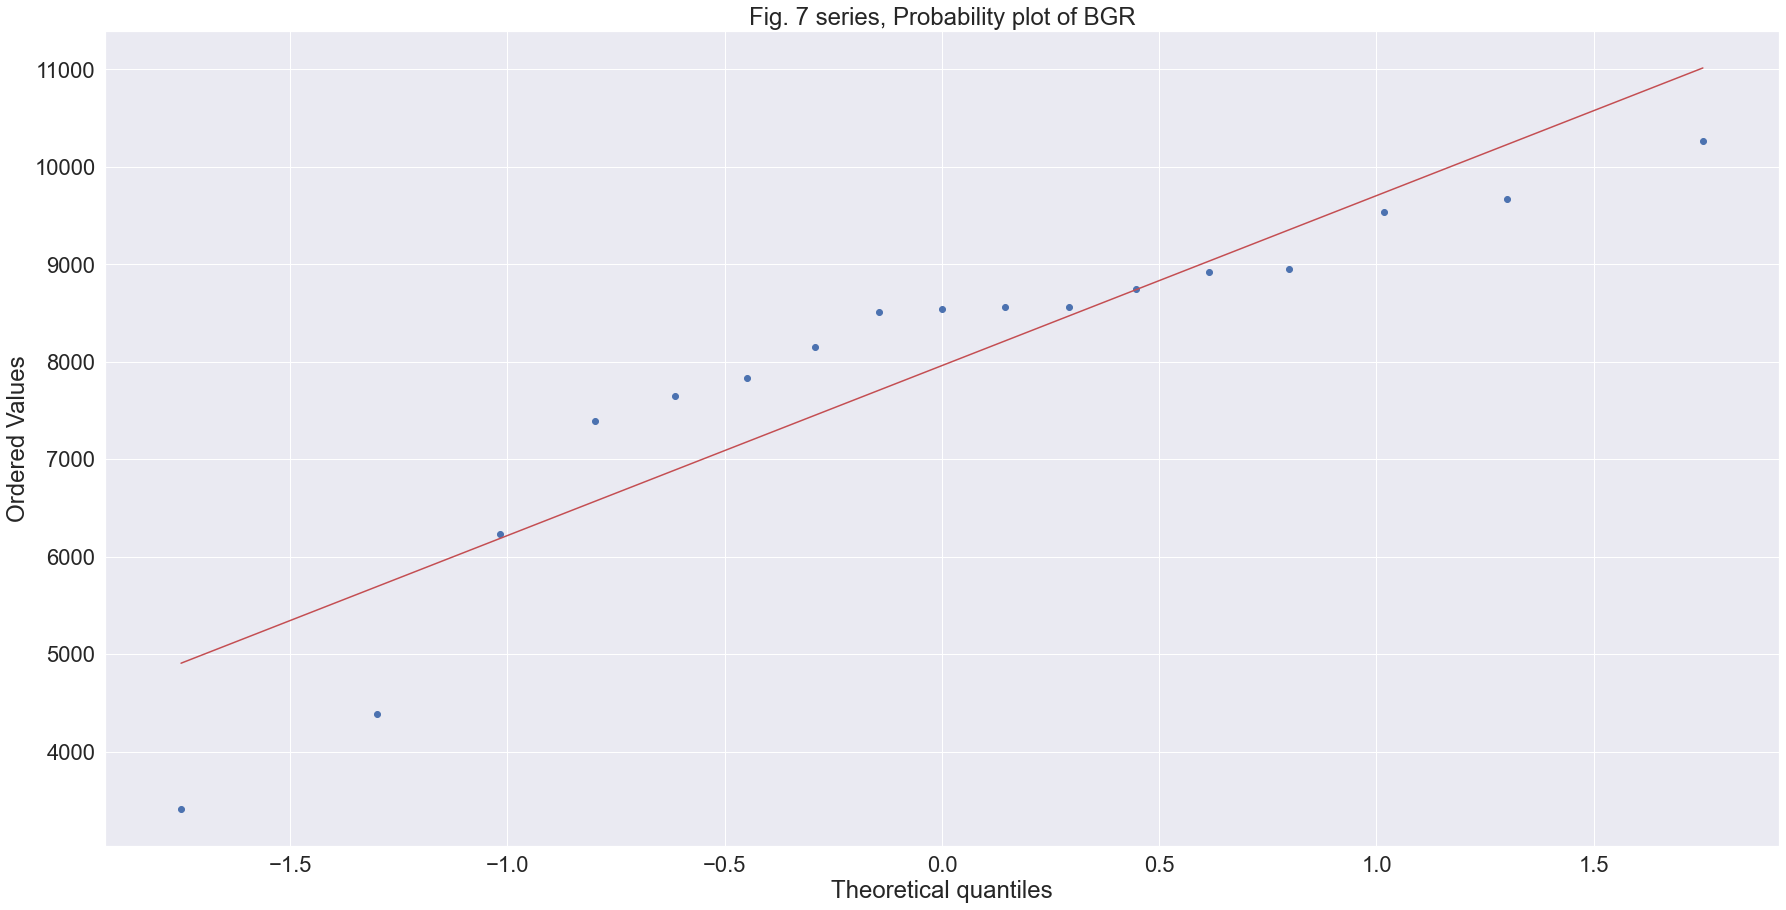

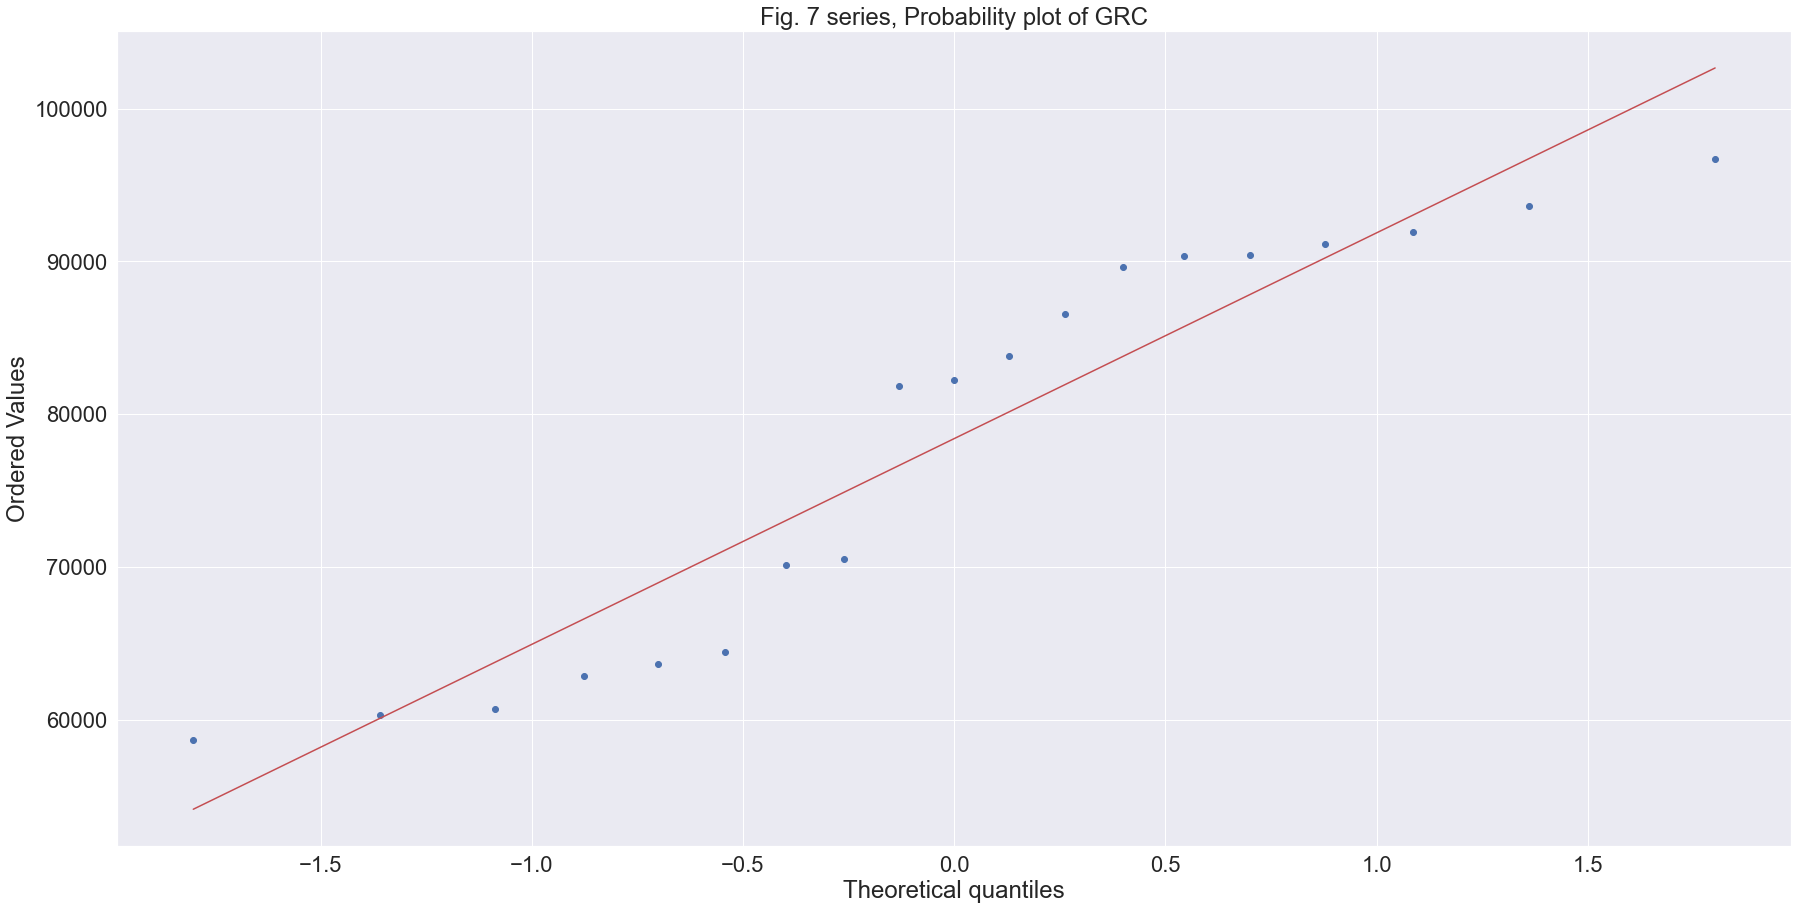

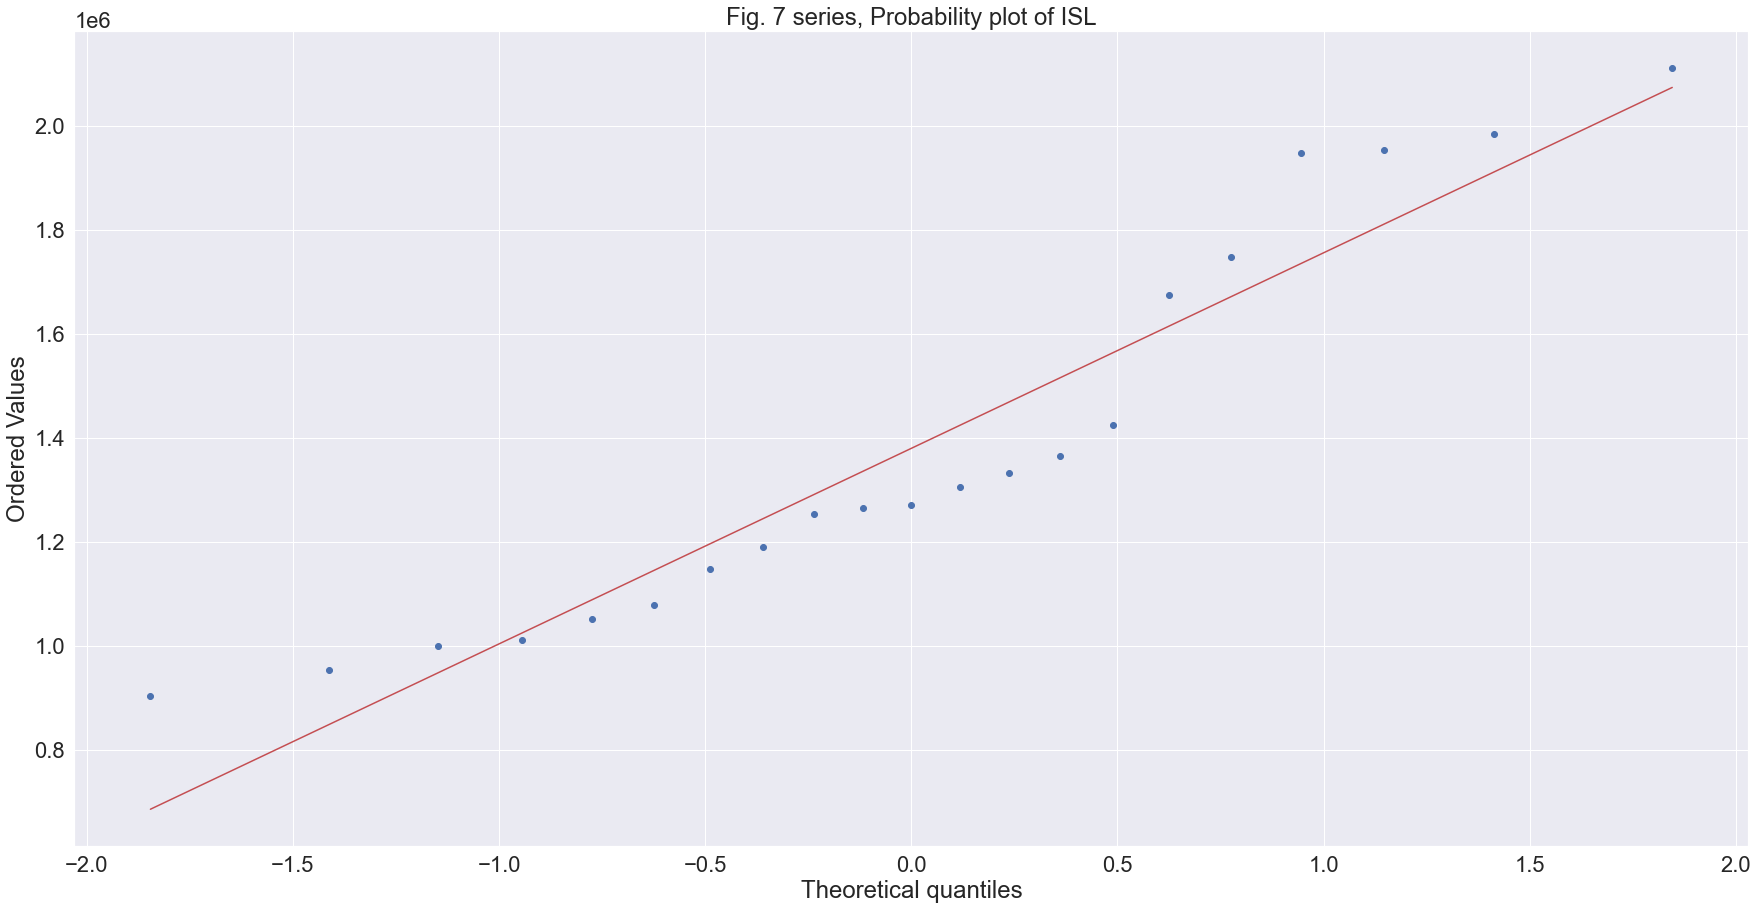

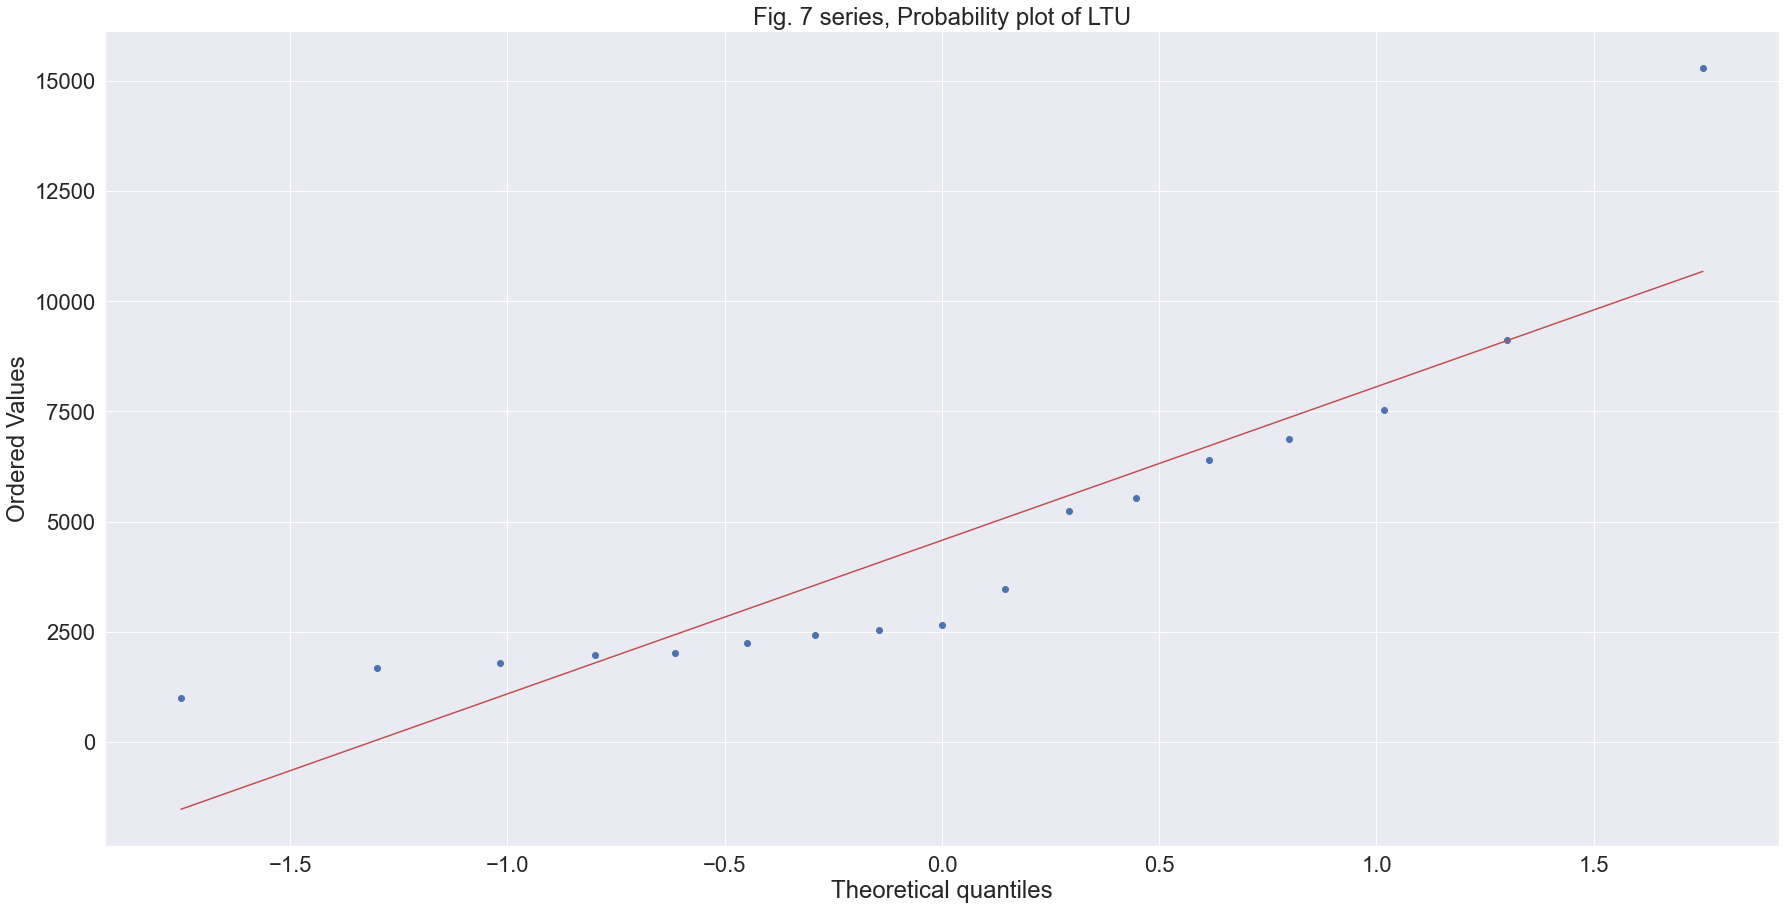

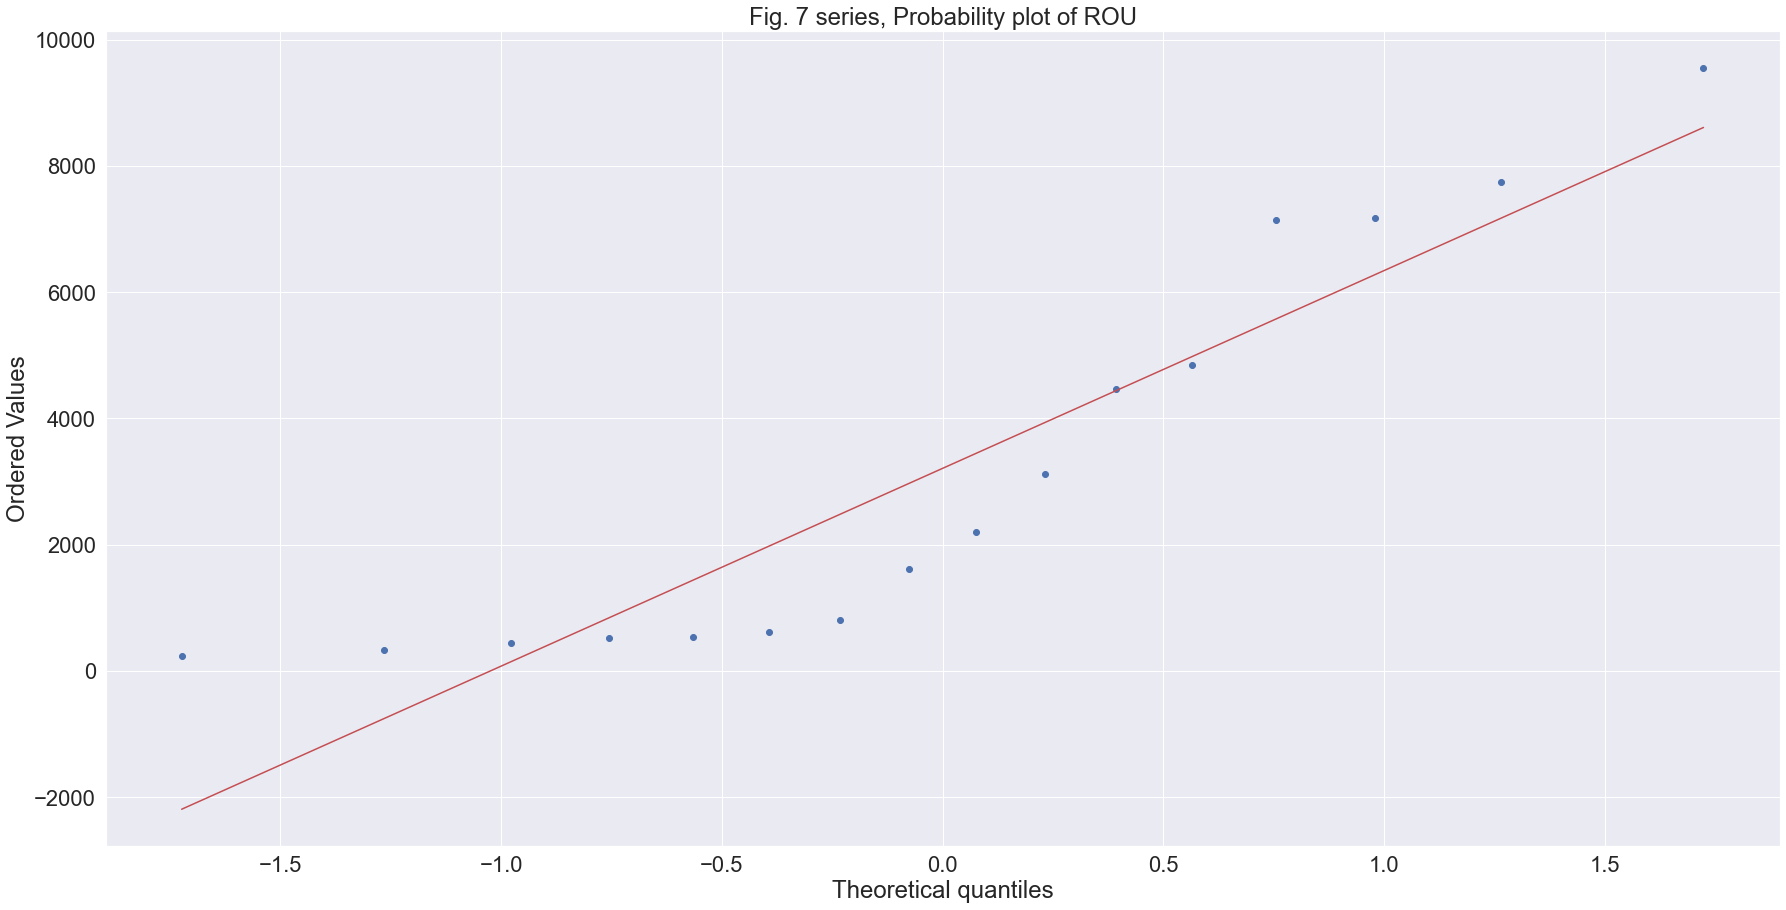

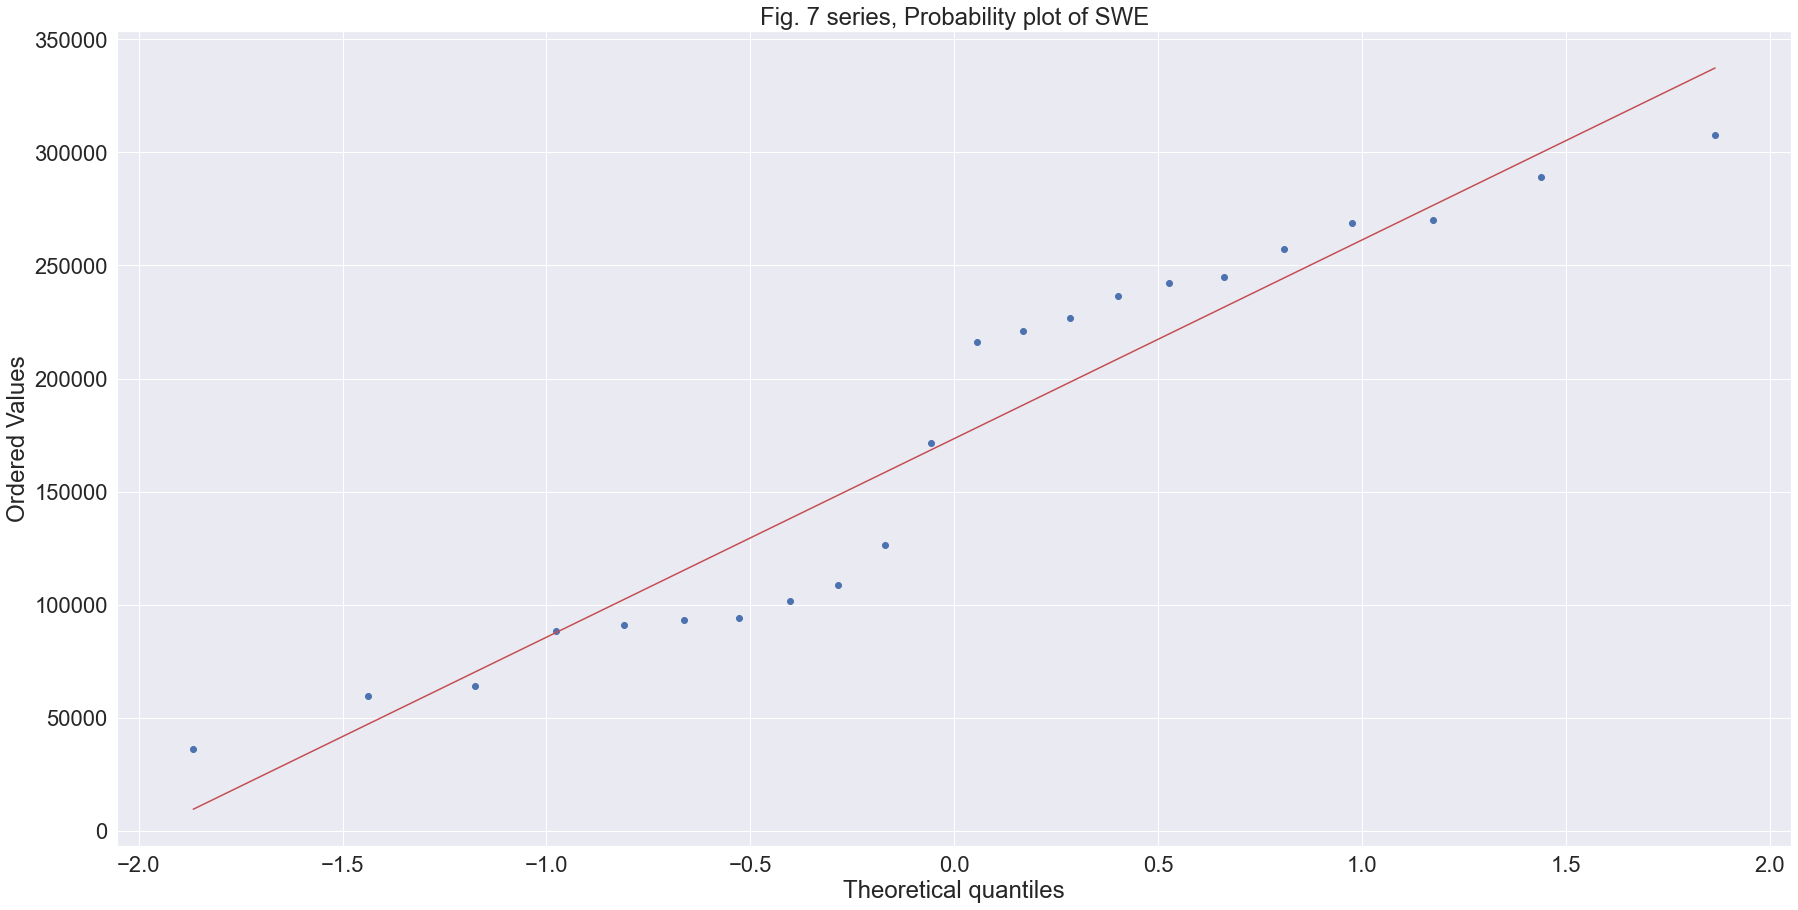

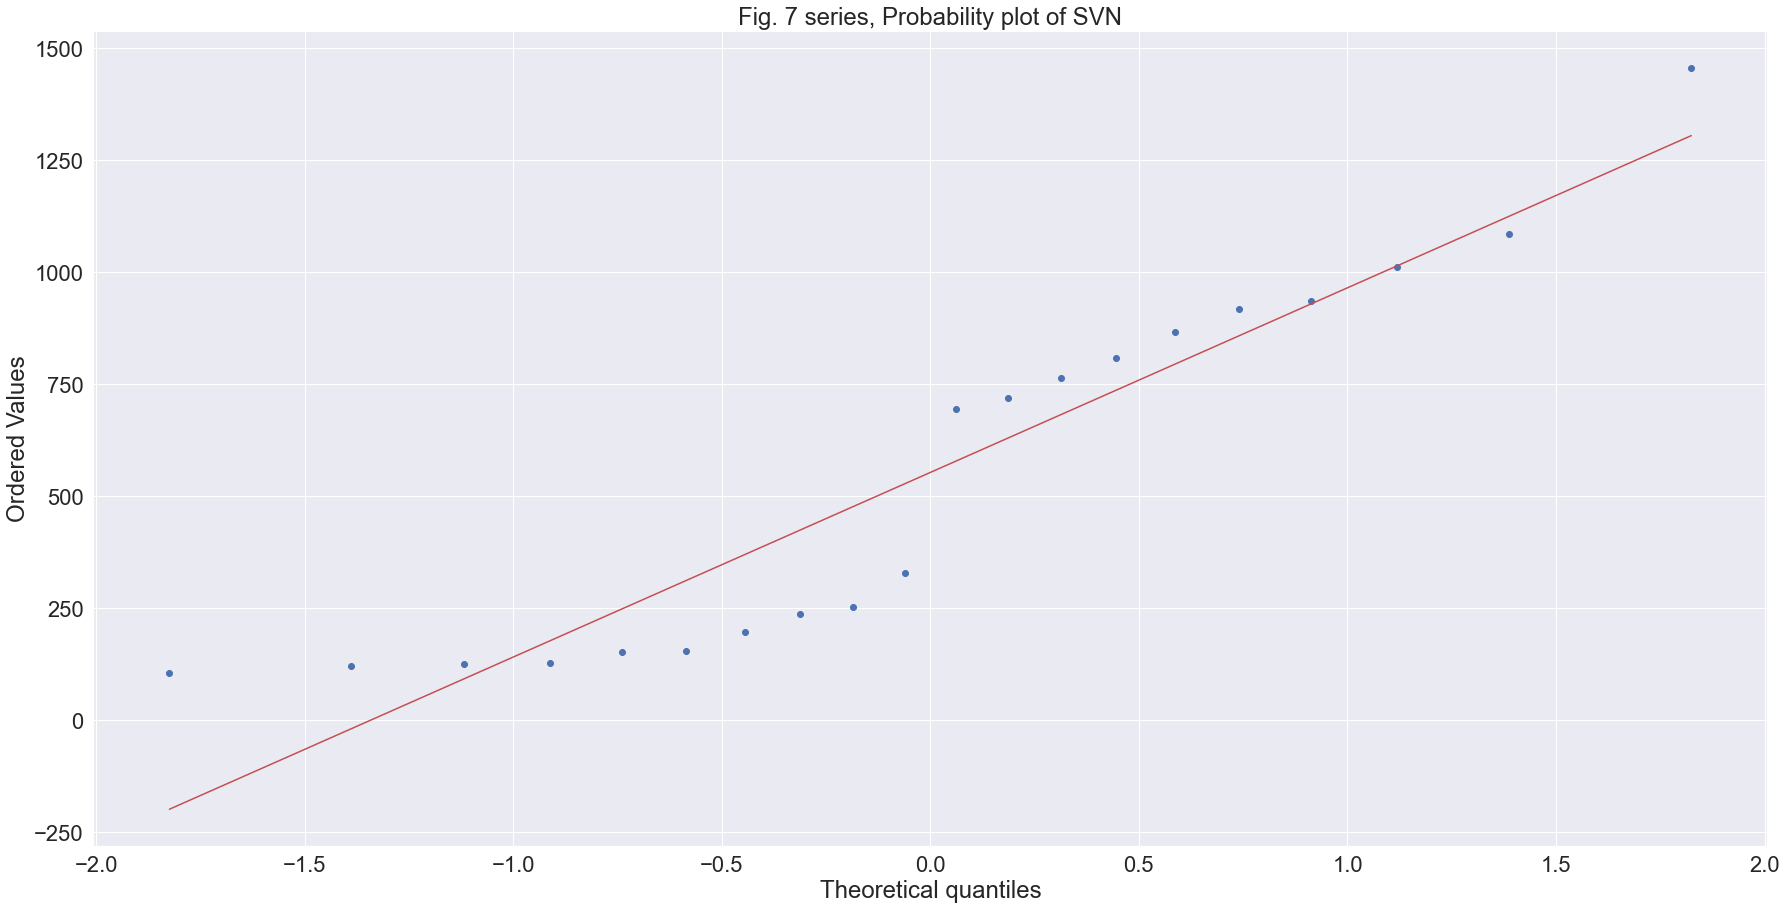

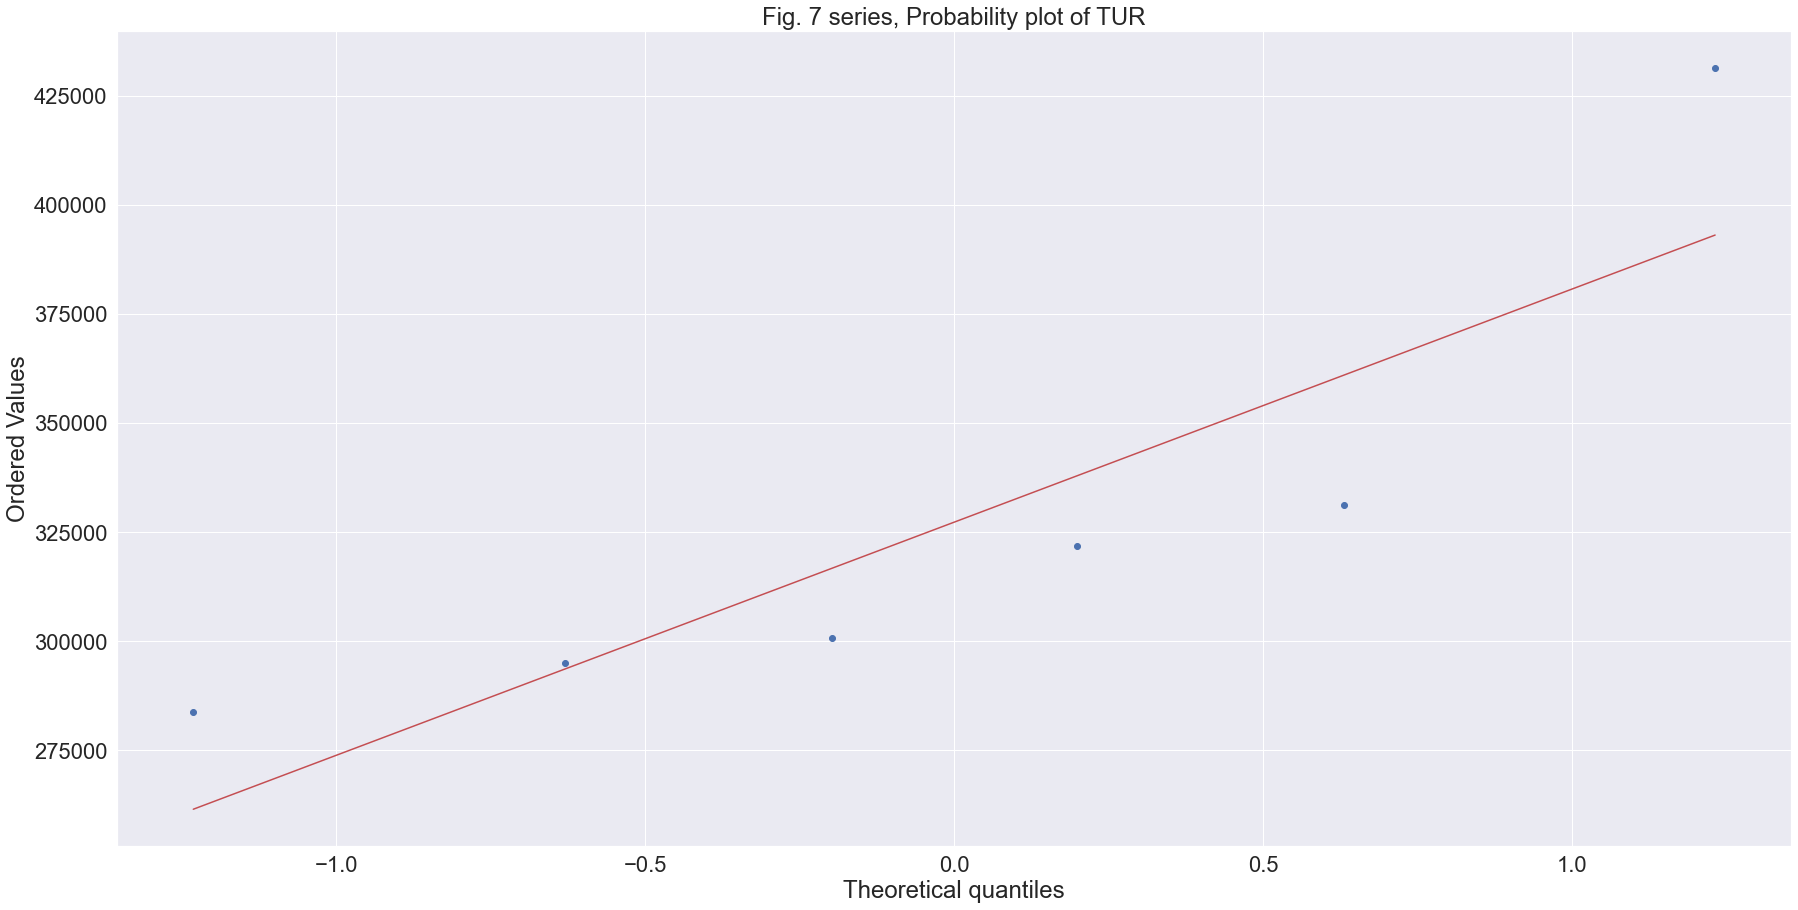

<Figure size 2160x1080 with 0 Axes>

In [60]:
for i in nonNormalDist:
    stats.probplot(mapChart.iloc[i,1:].dropna().astype(float), plot = plt) # Normal probability plots
    plt.title('Fig. 7 series, Probability plot of '+mapChart.iloc[i,0])
    plt.figure();   

The 8 countries above do not follow a normal distribution, checking their medians:

In [61]:
for i in nonNormalDist:
    print(mapChart.iloc[i,0],' - ',mapChart.iloc[i,1:].median())

BGR  -  8545.9366
GRC  -  82232.7
ISL  -  1271249.407
LTU  -  2650.857
ROU  -  1908.2855
SWE  -  193683.95
SVN  -  511.95000000000005
TUR  -  311202.1


In [62]:
# checking descriptive stats of non-normal data
mapChart.iloc[nonNormalDist,1:].apply(pd.DataFrame.describe, axis=1)

count          mean            std          min           25%  \
1    17.0  7.960580e+03    1795.591339    3408.0000  7.651900e+03   
6    19.0  7.839664e+04   13461.705071   58691.9000  6.403470e+04   
12   21.0  1.379405e+06  374348.912341  902421.8720  1.077313e+06   
14   17.0  4.574932e+03    3670.802496    1004.2530  2.026047e+03   
21   16.0  3.209894e+03    3178.309161     230.8460  5.323910e+02   
22   22.0  1.734642e+05   87147.091195   36393.7562  9.353953e+04   
23   20.0  5.532155e+02     415.330623     106.4467  1.546475e+02   
24    6.0  3.273072e+05   53917.363707  283855.6000  2.963782e+05   

             50%           75%           max  
1   8.545937e+03  8.919035e+03  1.026810e+04  
6   8.223270e+04  9.041314e+04  9.669425e+04  
12  1.271249e+06  1.674946e+06  2.110784e+06  
14  2.650857e+03  6.390700e+03  1.529270e+04  
21  1.908285e+03  5.419252e+03  9.553180e+03  
22  1.936840e+05  2.441665e+05  3.076928e+05  
23  5.119500e+02  8.795000e+02  1.456000e+03  
24  3.112021e+05  3.288279e+05  4.314431e+05

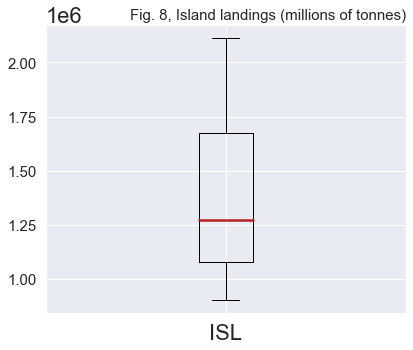

In [63]:
# assigning the data of each country to a variable
boxPlotBGR, boxPlotGRC, boxPlotISL, boxPlotLTU, boxPlotROU, boxPlotSWE, boxPlotSVN, boxPlotTUR = mapChart.iloc[1,1:].dropna(), mapChart.iloc[6,1:].dropna(), mapChart.iloc[12,1:].dropna(), mapChart.iloc[14,1:].dropna(), mapChart.iloc[21,1:].dropna() , mapChart.iloc[22,1:].dropna() , mapChart.iloc[23,1:].dropna(), mapChart.iloc[24,1:].dropna()

fig = plt.figure(figsize =(5, 4))

# Creating axes instance
ax = fig.add_axes([0,0,1,1])

# Setting properties of the representation of the median 
medianprops = dict(linewidth=2.5, color='firebrick')

# Creating plot of Island
ax.boxplot(boxPlotISL, medianprops=medianprops)

# Adding title and its position
plt.title("Fig. 8, Island landings (millions of tonnes)", loc='right', fontsize = 15)

# Setting size of the font from Y axis
plt.yticks(fontsize=15)

# x-axis labels
ax.set_xticklabels(['ISL'])

# show plot
plt.show()

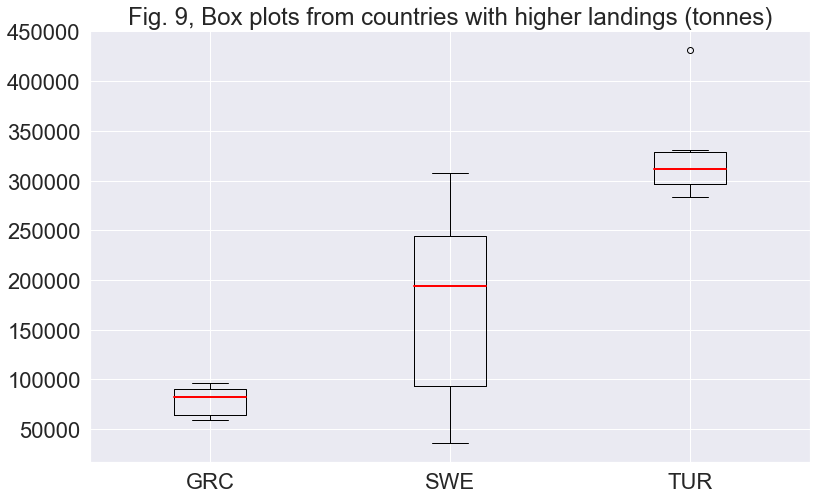

In [64]:
# First group box plot
boxPlotData2 = [boxPlotGRC, boxPlotSWE, boxPlotTUR]

fig = plt.figure(figsize =(10, 6))

# Creating axes instance
ax = fig.add_axes([0,0,1,1])
 
# Creating plot
bp = ax.boxplot(boxPlotData2)

# changing color and linewidth of medians
for median in bp['medians']:
    median.set(color ='red', linewidth = 2)

# x-axis labels
ax.set_xticklabels(['GRC', 'SWE', 'TUR'])

# Adding title
plt.title("Fig. 9, Box plots from countries with higher landings (tonnes)")

# show plot
plt.show()

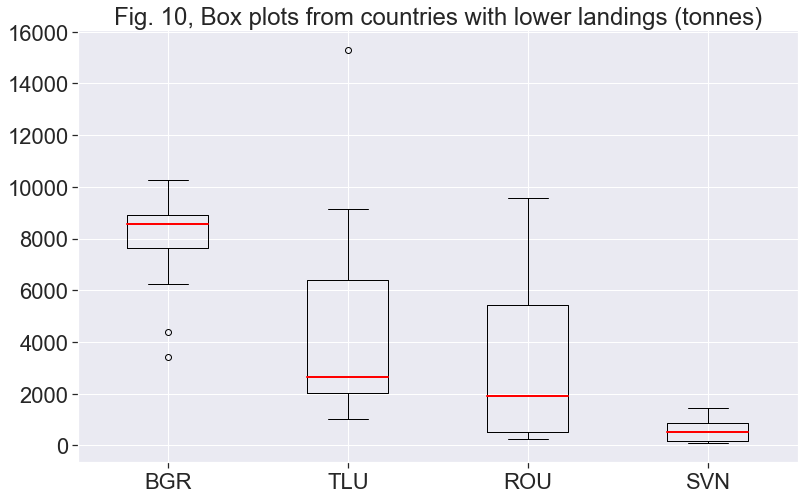

In [65]:
# Second group
boxPlotData = [boxPlotBGR, boxPlotLTU, boxPlotROU, boxPlotSVN]
fig = plt.figure(figsize =(10, 6))
 
# Creating axes instance
ax = fig.add_axes([0,0,1,1])
 
# Creating plot
bp = ax.boxplot(boxPlotData)

# changing color and linewidth of medians
for median in bp['medians']:
    median.set(color ='red', linewidth = 2)

# x-axis labels
ax.set_xticklabels(['BGR', 'TLU', 'ROU', 'SVN'])
 
# Adding title
plt.title("Fig. 10, Box plots from countries with lower landings (tonnes)")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show();


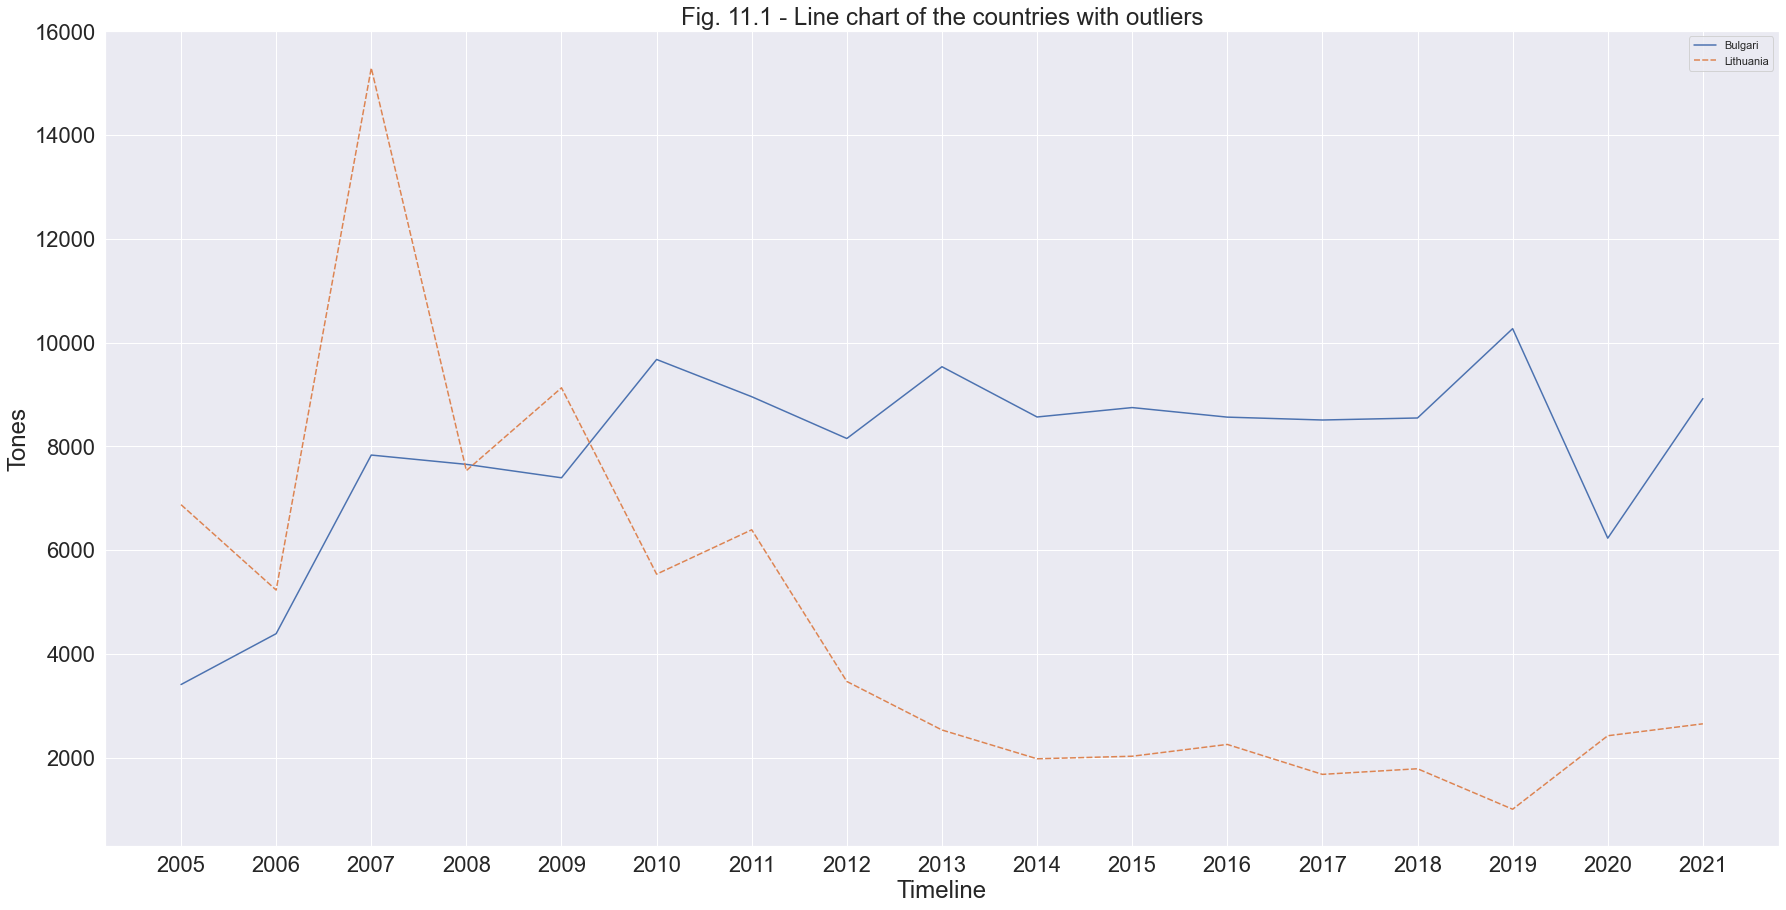

In [66]:
# each plot is specified by its corresponding row (total aquatic animals, and total aquatic animal for human consumption)
ax = sns.lineplot(data=[boxPlotBGR, boxPlotLTU]).set(
    xlabel ="Timeline", 
    ylabel = "Tones", 
    title = 'Fig. 11.1 - Line chart of the countries with outliers')

# setting up size and legend
sns.set(rc={'figure.figsize':(10,5)}) # chart size
plt.legend(labels=['Bulgari', 'Lithuania']);

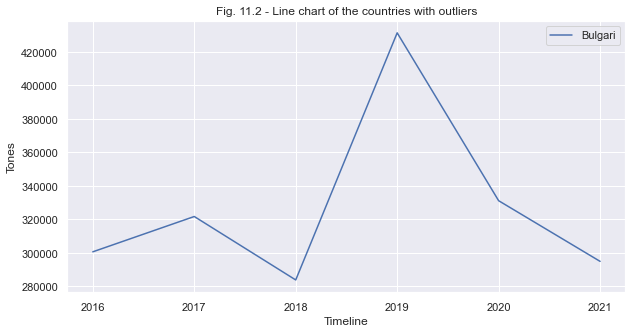

In [67]:
# each plot is specified by its corresponding row (total aquatic animals, and total aquatic animal for human consumption)
ax = sns.lineplot(data=[boxPlotTUR]).set(
    xlabel ="Timeline", 
    ylabel = "Tones", 
    title = 'Fig. 11.2 - Line chart of the countries with outliers')

# setting up size and legend
sns.set(rc={'figure.figsize':(10,5)}) # chart size
plt.legend(labels=['Bulgari']);

### Normal data

In [68]:
# Getting the indexes of the rows (countries) which show a normal distribution
normalDist = np.delete(mapChart.index.to_numpy(), nonNormalDist)
normalDist

array([ 0,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 15, 16, 17, 18, 19, 20],
      dtype=int64)

Histograms per country

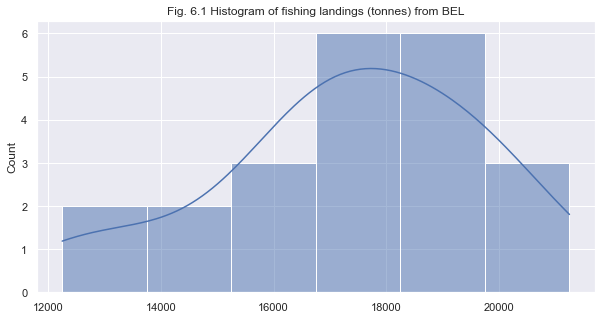

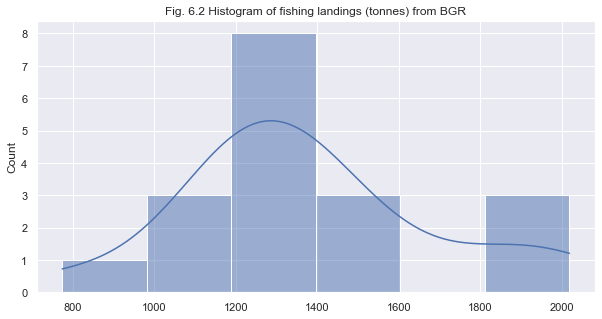

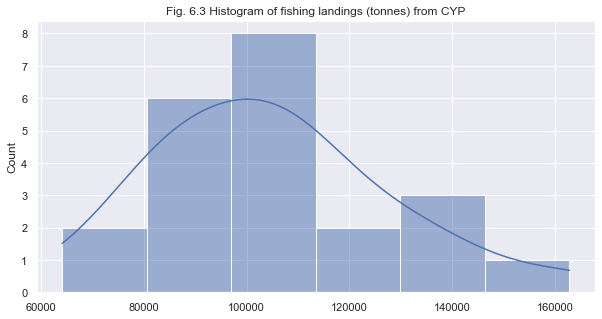

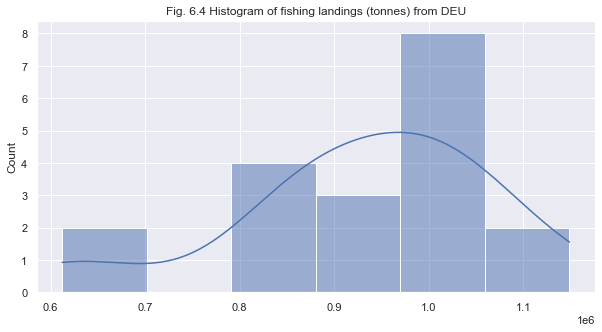

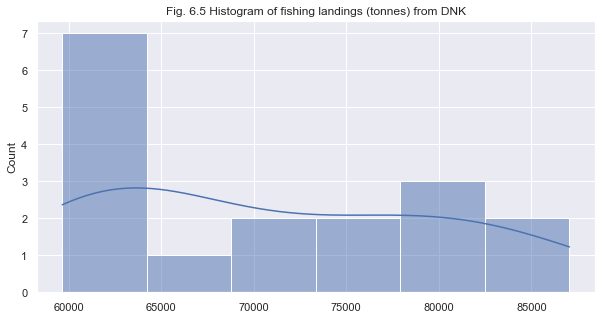

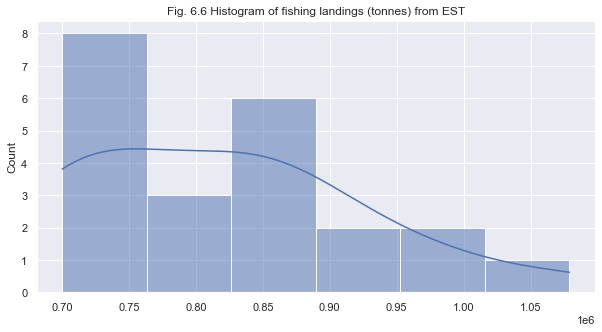

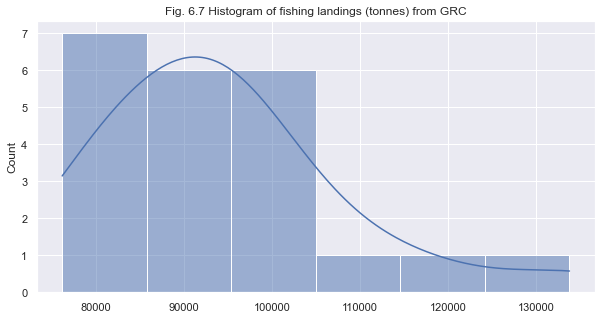

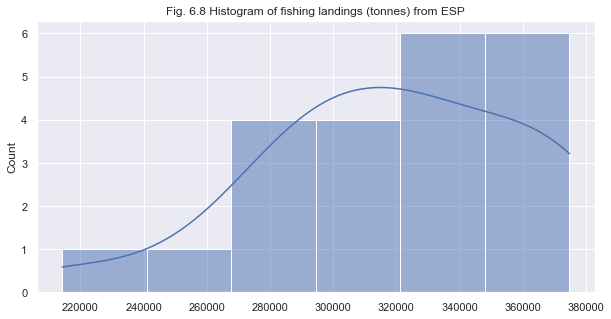

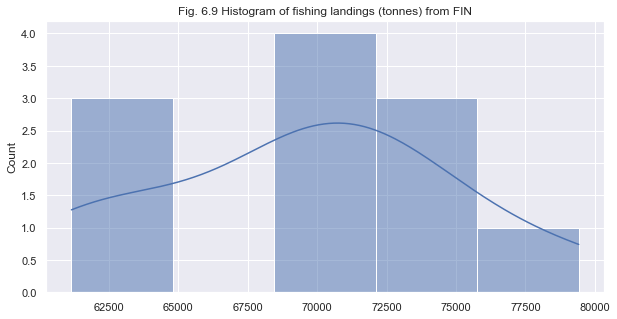

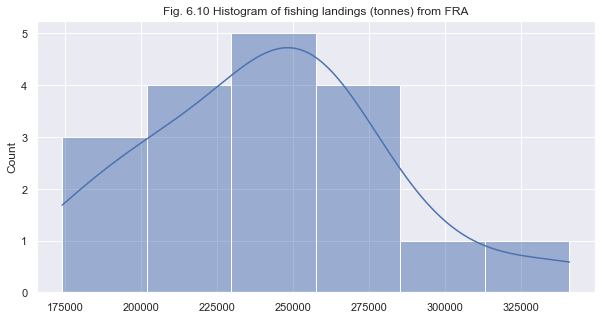

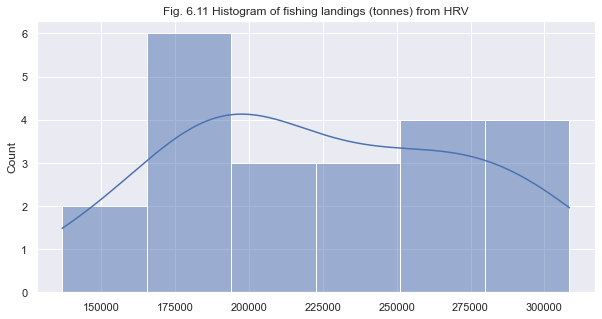

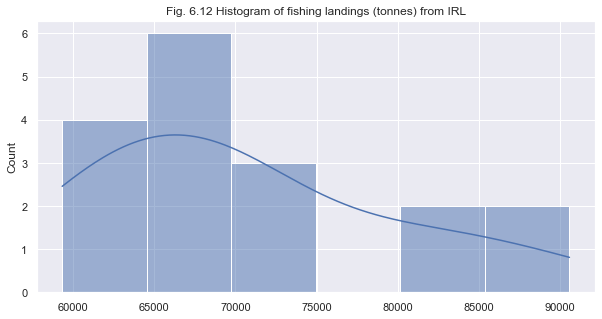

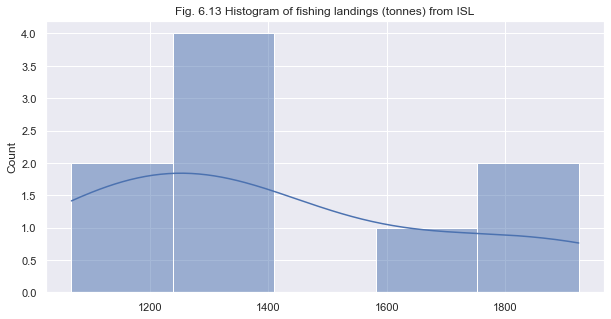

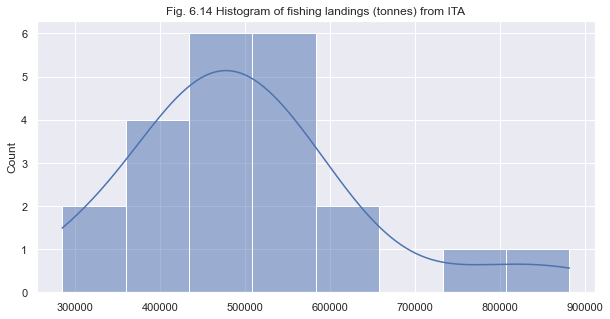

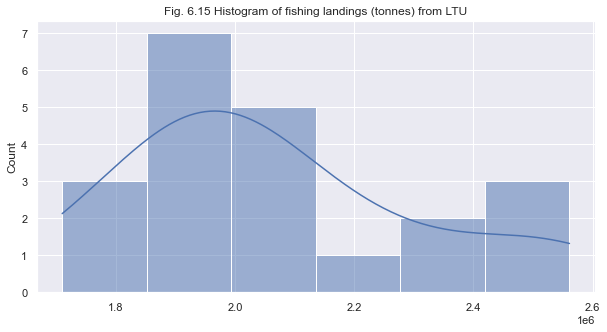

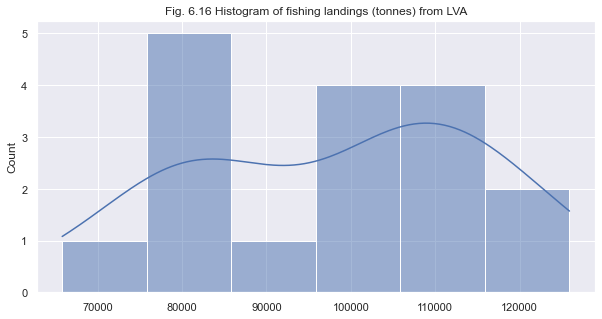

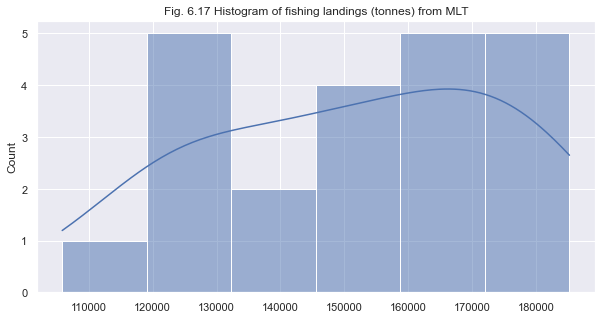

In [69]:
sns.histplot(data = mapChart.iloc[normalDist[0],1:], kde=True).set(title='Fig. 6.1 Histogram of fishing landings (tonnes) from '+mapChart.iloc[0,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[1],1:], kde=True).set(title='Fig. 6.2 Histogram of fishing landings (tonnes) from '+mapChart.iloc[1,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[2],1:], kde=True).set(title='Fig. 6.3 Histogram of fishing landings (tonnes) from '+mapChart.iloc[2,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[3],1:], kde=True).set(title='Fig. 6.4 Histogram of fishing landings (tonnes) from '+mapChart.iloc[3,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[4],1:], kde=True).set(title='Fig. 6.5 Histogram of fishing landings (tonnes) from '+mapChart.iloc[4,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[5],1:], kde=True).set(title='Fig. 6.6 Histogram of fishing landings (tonnes) from '+mapChart.iloc[5,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[6],1:], kde=True).set(title='Fig. 6.7 Histogram of fishing landings (tonnes) from '+mapChart.iloc[6,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[7],1:], kde=True).set(title='Fig. 6.8 Histogram of fishing landings (tonnes) from '+mapChart.iloc[7,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[8],1:], kde=True).set(title='Fig. 6.9 Histogram of fishing landings (tonnes) from '+mapChart.iloc[8,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[9],1:], kde=True).set(title='Fig. 6.10 Histogram of fishing landings (tonnes) from '+mapChart.iloc[9,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[10],1:], kde=True).set(title='Fig. 6.11 Histogram of fishing landings (tonnes) from '+mapChart.iloc[10,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[11],1:], kde=True).set(title='Fig. 6.12 Histogram of fishing landings (tonnes) from '+mapChart.iloc[11,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[12],1:], kde=True).set(title='Fig. 6.13 Histogram of fishing landings (tonnes) from '+mapChart.iloc[12,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[13],1:], kde=True).set(title='Fig. 6.14 Histogram of fishing landings (tonnes) from '+mapChart.iloc[13,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[14],1:], kde=True).set(title='Fig. 6.15 Histogram of fishing landings (tonnes) from '+mapChart.iloc[14,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[15],1:], kde=True).set(title='Fig. 6.16 Histogram of fishing landings (tonnes) from '+mapChart.iloc[15,0], xlabel=None)
plt.show()
sns.histplot(data = mapChart.iloc[normalDist[16],1:], kde=True).set(title='Fig. 6.17 Histogram of fishing landings (tonnes) from '+mapChart.iloc[16,0], xlabel=None)
plt.show()

Normal probability plots:

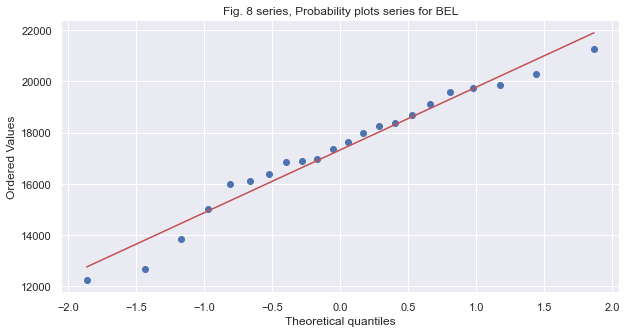

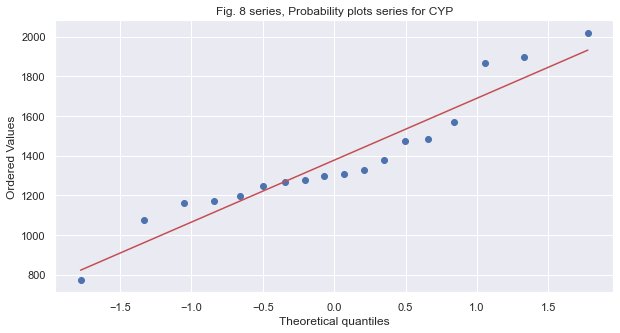

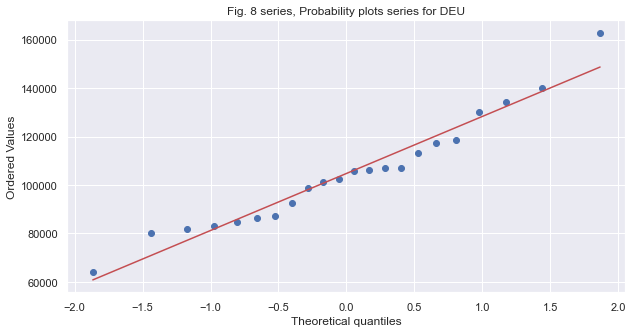

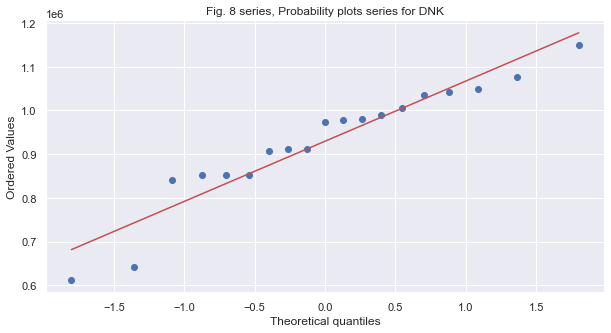

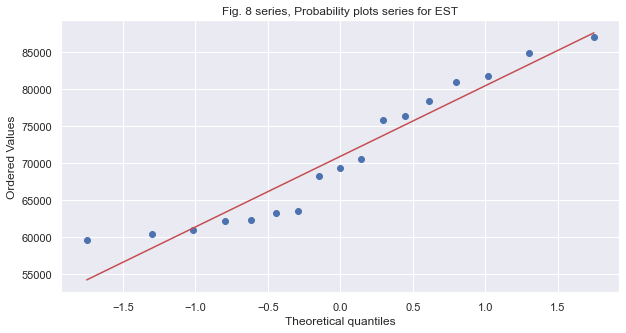

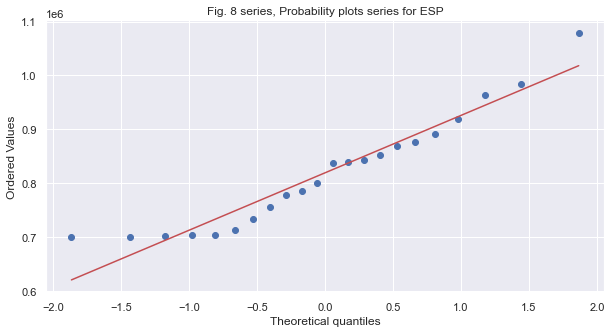

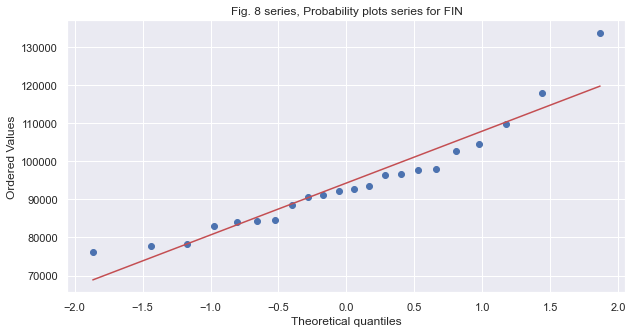

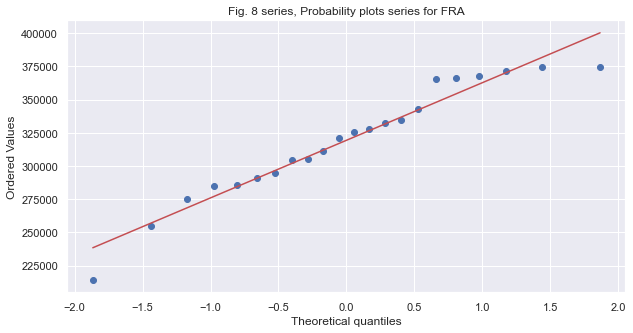

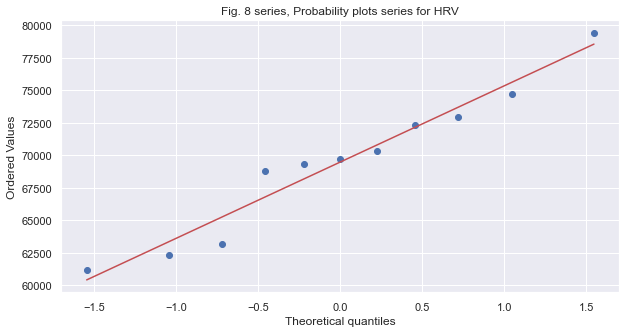

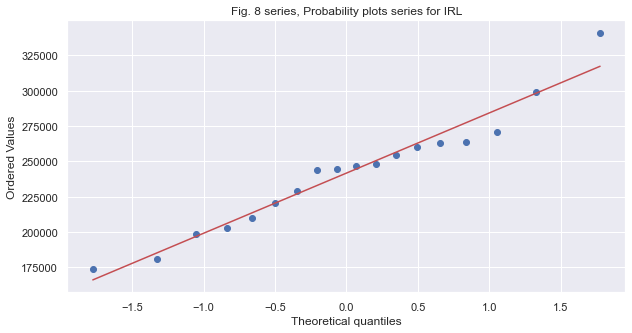

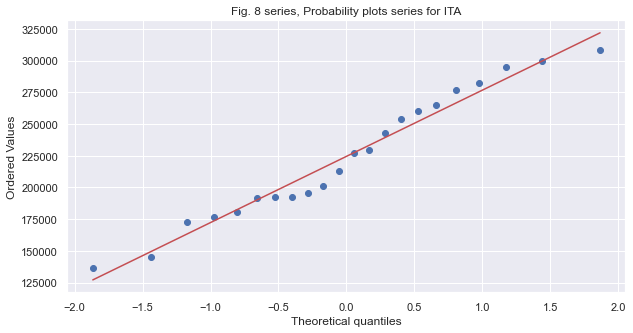

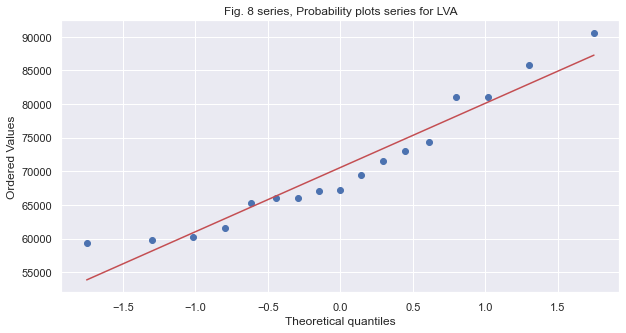

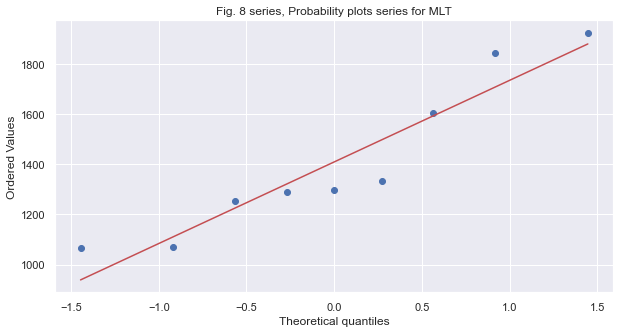

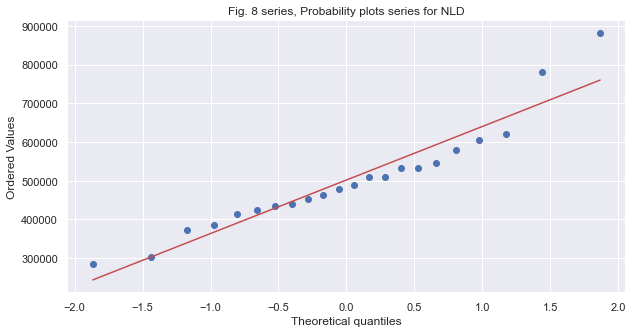

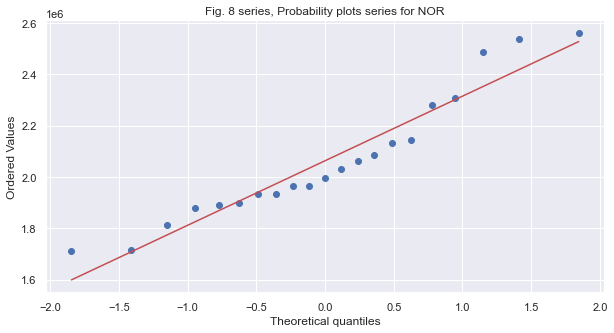

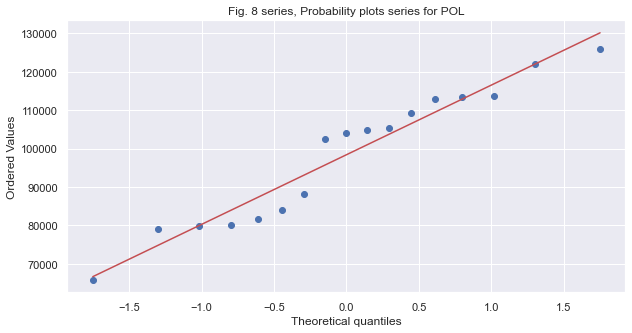

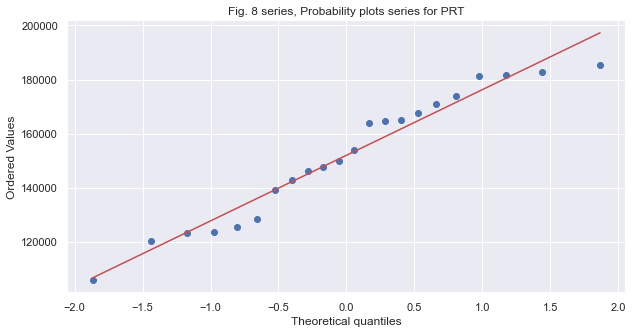

<Figure size 720x360 with 0 Axes>

In [70]:
for i in normalDist:
    stats.probplot(mapChart.iloc[i,1:].dropna().astype(float), plot = plt)
    plt.title("Fig. 8 series, Probability plots series for "+ mapChart.iloc[i,0])
    plt.figure();   

In [71]:
# checking descriptive stats of normal data
mapChart.iloc[normalDist,1:].apply(pd.DataFrame.describe, axis=1)

count          mean            std           min           25%  \
0    22.0  1.732753e+04    2372.849869  1.225580e+04  1.619545e+04   
2    18.0  1.377258e+03     307.882721  7.738000e+02  1.208161e+03   
3    22.0  1.047739e+05   22959.447745  6.410026e+04  8.673875e+04   
4    19.0  9.297020e+05  136486.314610  6.123031e+05  8.529929e+05   
5    17.0  7.093594e+04    9348.062803  5.964835e+04  6.234024e+04   
7    22.0  8.192576e+05  105325.431712  7.002376e+05  7.177435e+05   
8    22.0  9.431751e+04   13666.350137  7.621030e+04  8.443993e+04   
9    22.0  3.193813e+05   42428.360767  2.142133e+05  2.922264e+05   
10   11.0  6.947994e+04    5539.767941  6.115392e+04  6.600803e+04   
11   18.0  2.417279e+05   41152.941282  1.739820e+05  2.123042e+05   
13   22.0  2.245034e+05   50365.302295  1.367714e+05  1.917761e+05   
15   17.0  7.056130e+04    9333.541155  5.931682e+04  6.535733e+04   
16    9.0  1.409432e+03     313.317930  1.066900e+03  1.252400e+03   
17   22.0  5.019587e+05  138166.773269  2.845652e+05  4.268956e+05   
18   21.0  2.063101e+06  247665.230715  1.710271e+06  1.898295e+06   
19   17.0  9.838819e+04   17583.770340  6.578990e+04  8.168800e+04   
20   22.0  1.519701e+05   23602.595937  1.058602e+05  1.310508e+05   

             50%           75%           max  
0   1.749750e+04  1.900785e+04  2.124330e+04  
2   1.303100e+03  1.480250e+03  2.019100e+03  
3   1.041604e+05  1.163026e+05  1.628480e+05  
4   9.743627e+05  1.020567e+06  1.148943e+06  
5   6.940570e+04  7.837002e+04  8.705941e+04  
7   8.181848e+05  8.744202e+05  1.079019e+06  
8   9.251993e+04  9.799948e+04  1.337703e+05  
9   3.236014e+05  3.595426e+05  3.747793e+05  
10  6.970074e+04  7.262333e+04  7.942169e+04  
11  2.456730e+05  2.623813e+05  3.409759e+05  
13  2.199450e+05  2.639900e+05  3.084880e+05  
15  6.728469e+04  7.438407e+04  9.059840e+04  
16  1.297600e+03  1.606500e+03  1.924700e+03  
17  4.840446e+05  5.430598e+05  8.822330e+05  
18  1.996260e+06  2.145732e+06  2.561153e+06  
19  1.039379e+05  1.128673e+05  1.259079e+05  
20  1.519386e+05  1.700615e+05  1.852088e+05

In [72]:
print('country\t mean\t    standard dev\n--------------------------------') # header of the table. /t represents a TAB and /n is the new line character
for i in normalDist:
    print(mapChart.iloc[i,0],' - ',"{:.2f}".format(mapChart.iloc[i,1:].mean()).center(10) + ' - ' +"{:.2f}".format(mapChart.iloc[i,1:].std()).center(7))

country	 mean	    standard dev
--------------------------------
BEL  -   17327.53  - 2372.85
CYP  -   1377.26   -  307.88
DEU  -  104773.92  - 22959.45
DNK  -  929701.98  - 136486.31
EST  -   70935.94  - 9348.06
ESP  -  819257.61  - 105325.43
FIN  -   94317.51  - 13666.35
FRA  -  319381.32  - 42428.36
HRV  -   69479.94  - 5539.77
IRL  -  241727.88  - 41152.94
ITA  -  224503.45  - 50365.30
LVA  -   70561.30  - 9333.54
MLT  -   1409.43   -  313.32
NLD  -  501958.68  - 138166.77
NOR  -  2063100.78 - 247665.23
POL  -   98388.19  - 17583.77
PRT  -  151970.11  - 23602.60


Is there a significant difference between the landings of Ireland and Italy with a confidence of 95%?

In [73]:
# Italian mean
dataITL = mainDF.loc[163388][5:27]
dataITL

2000    295096.0
2001    308488.0
2002    253802.0
2003    265122.0
2004    260594.0
2005    281987.0
2006    299266.0
2007    276743.1
2008    227159.6
2009    242581.3
2010    229236.3
2011    212730.5
2012    195838.6
2013    172906.8
2014    177019.4
2015    191634.1
2016    192602.6
2017    192202.0
2018    201523.6
2019    180296.2
2020    136771.4
2021    145475.3
Name: 163388, dtype: object

In [74]:
# Irish samples
dataIRE = mainDF.loc[163386][5:23]
dataIRE

2000       202908.5
2001       254302.2
2002       173982.0
2003       299193.0
2004       260449.9
2005       198958.3
2006       220211.8
2007       244295.7
2008       209668.4
2009       247050.4
2010      247841.15
2011      180970.09
2012     340975.871
2013    229092.8118
2014    270835.1244
2015    243580.8393
2016    263025.0901
2017    263760.6687
Name: 163386, dtype: object

In [75]:
dataIRE.var() == dataITL.var()

False

In [76]:
dataIRE.var()

1693564576.1432295

In [77]:
dataITL.var()

2536663675.2768836

-> What is the average price of all the fishery products in Ireland?

In [78]:
irishDF.iloc[7565]

pres                 TOTAL
species                F00
dest_use             TOTAL
unit                   EUR
2000                   NaN
2001                   NaN
2002        170811607.1477
2003        253012674.4693
2004        193896950.0584
2005        149047926.3208
2006         314809957.385
2007         364209797.259
2008           249668492.0
2009        236062877.1893
2010        288301571.7924
2011        261199969.9945
2012        396736171.0518
2013        299492068.9533
2014        507926065.6439
2015        308953184.1369
2016        485937308.4813
2017         292143864.614
2018                   NaN
2019                   NaN
2020                   NaN
2021                   NaN
Name: 7565, dtype: object

In [79]:
# Selecting the row that holds total fishery products (species F00) per price and dropping Nan's 
confInt = irishDF.iloc[7565,4:].dropna()

In [80]:
stats.t.interval(alpha=[0.95, 0.99], df=len(confInt)-1, loc=np.mean(confInt), scale=stats.sem(confInt))

(array([2.44480951e+08, 2.23909664e+08]),
 array([3.52045360e+08, 3.72616647e+08]))

In [81]:
irishDF.query('species == "F45" & pres == "TOTAL" & dest_use == "TOTAL" & unit == "TPW"').isna().sum()

pres        0
species     0
dest_use    0
unit        0
2000        0
2001        0
2002        0
2003        0
2004        0
2005        0
2006        0
2007        0
2008        0
2009        0
2010        0
2011        0
2012        0
2013        0
2014        0
2015        0
2016        0
2017        0
2018        1
2019        1
2020        1
2021        1
dtype: int64

In [82]:
irishDF.query('species == "F45" & pres == "TOTAL" & dest_use == "TOTAL" & unit == "EUR"').isna().sum()

pres        0
species     0
dest_use    0
unit        0
2000        1
2001        1
2002        0
2003        0
2004        0
2005        0
2006        0
2007        0
2008        0
2009        0
2010        0
2011        0
2012        0
2013        0
2014        0
2015        0
2016        0
2017        0
2018        1
2019        1
2020        1
2021        1
dtype: int64

### Inputing 

In [83]:
imputer = MissForest()
X_imputed = imputer.fit_transform(mapChart.iloc[:,1:])

C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 0


C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 1


C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 2


C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 3


C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 4


C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\elrec\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

Iteration: 5


In [84]:
type(X_imputed)

numpy.ndarray

In [85]:
# Creating df out of the np array 
mapChartInp = pd.DataFrame(X_imputed, columns = mapChart.iloc[:,1:].columns)

In [86]:
# adding geo column, column with index 0, labelled 'geo' and entered the values as a numpy array
mapChartInp.insert(0,'geo',mapChart['geo'].to_numpy())

In [87]:
# checking distributions again with Shapiro-Wilk
for index, row in mapChartInp.iterrows():
    if shapiro(mapChartInp.iloc[index,1:]).pvalue < 0.05:
        print(mapChartInp.iloc[index,0],' - ', shapiro(mapChartInp.iloc[index,1:]).pvalue)

BGR  -  4.889051297141123e-07
CYP  -  5.750578679908358e-08
GRC  -  0.046862371265888214
LTU  -  3.541015985319973e-06
MLT  -  2.8099012183702143e-07
NOR  -  0.0007417086162604392
ROU  -  3.074223286603228e-06
SWE  -  0.033335182815790176
SVN  -  1.0188178301007156e-08
TUR  -  0.02729327790439129


By comparing outputs, three countries switched to a non-normal distribution (rows 6,12,24) and five countries have switched to a normal distribution (2,5,15,16,18). All the others keep the same distribution

In [88]:
# Melting the df to prepare the input of choropleth
mapChartInpMelt = mapChartInp.melt(id_vars=['geo']).sort_values(by = ['geo', 'variable']) # no need to sort rows per geo and year for choropleth input, it just betters the presentation 

In [89]:
mapChartInpMelt

geo variable     value
0    BEL     2000   17987.3
25   BEL     2001   18357.4
50   BEL     2002   19874.4
75   BEL     2003   20278.8
100  BEL     2004   21243.3
..   ...      ...       ...
449  TUR     2017  321748.1
474  TUR     2018  283855.6
499  TUR     2019  431443.1
524  TUR     2020  331187.8
549  TUR     2021  294952.3

[550 rows x 3 columns]

In [90]:
fig = px.choropleth(mapChartInpMelt,
                    locations = "geo",
                    animation_frame = "variable",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    color="value", # showing colors according to the year 
                    hover_name="value",) # column to display in hover information
                    
fig.update_layout(title_text = 'Fig. 12, European fish landings in tonnes') # the geo_scope = 'europe' does not include Turkey, candidate country to became part of the UE

fig.show()

In [91]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
categoricalDF         DataFrame           freq pres species <...>[382236 rows x 7 columns]
cuantitativeColumns   DataFrame            2000  2001  2002 <...>382236 rows x 22 columns]
irishDF               DataFrame          pres species dest_u<...>[10147 rows x 26 columns]
mainDF                DataFrame           pres species dest_<...>194706 rows x 27 columns]
mapChart              DataFrame        geo       2000       <...>n\n[25 rows x 23 columns]
mapChartInp           DataFrame        geo         2000     <...>n\n[25 rows x 23 columns]
mapChartInpMelt       DataFrame         geo variable     val<...>n\n[550 rows x 3 columns]


pres              TOTAL
species             F01
dest_use          TOTAL
unit                TPW

## Sentiment analysis

In [92]:
# # loading API keys
# config = dotenv_values(".env")

# bearer_token = config["BEARER_TOKEN"]

# search_url = "https://api.twitter.com/2/tweets/search/recent"

# # Optional params: start_time,end_time,since_id,until_id,max_results,next_token,
# # expansions,tweet.fields,media.fields,poll.fields,place.fields,user.fields
# # query_params = {'query': '(from:twitterdev -is:retweet) OR #twitterdev','tweet.fields': 'author_id', "max_results":"10"}
# query_params = {
#     'query' : '"Genetically modified food" OR "gm food" -is:retweet', # -is:retweet -> avoids retweets
#     "max_results":"100", # number of results we'll get
#     "start_time": "2022-12-31T02:31:00Z",
#     "end_time": "2023-01-01T00:00:00Z"
    
# }

# # Token authentication method
# def bearer_oauth(r):
#     r.headers["Authorization"] = f"Bearer {bearer_token}"
#     r.headers["User-Agent"] = "v2RecentSearchPython"
#     return r

# # Setting the query
# def connect_to_endpoint(url, params):
#     response = requests.get(url, auth=bearer_oauth, params=params) # how we set the request itself with .get
    
#     return response.json()

# # Querying the API
# json_response = connect_to_endpoint(search_url, query_params)

# # Parsing the response
# parsedRes4 = json.dumps(json_response, indent=4, sort_keys=True, ensure_ascii=True) # indent 4 to look nice indent. ascii to get emoties etc.
# print(parsedRes4)

In [93]:
# # Saving the variable holding tweets to a text file
# file = open("tweets.json", "w")
# file.write(parsedRes)
# file.close

In [94]:
# # Appending the other variables to the same text file
# file = open("tweets.json", "a")
# file.write('\n'+parsedRes4)
# file.close

In [95]:
# !pip install tweepy
# import tweepy

# paginator = tweepy.Paginator(
#     json_response,                         # The method you want to use    
#     exclude=['retweets', 'replies'],       # Some argument for this method
#     start_time="2022-01-01T00:00:00Z",     # Some argument for this method
#     max_results=100                        # How many tweets asked per request
# )

# for tweet in paginator.flatten(limit=250): # Total number of tweets to retrieve
#     print(tweet)

Extracting the key-value pairs with the tweets only. Resulting appended file created from git bash (> tweetsText.csv)

In [102]:
with open(r'tweets.txt', 'r') as fp:
    
    # read all lines using readline()
    lines = fp.readlines()
    
    for row in lines:
        # check if string present on a current line
        if row.find('text') != -1:  # find() method returns -1 if the value is not found
            file1 = open("tweetsText.csv", "a")  # append mode
            file1.write(row.lstrip().replace('"text": "', ''))
            file1.close()            

In [109]:
df = pd.read_csv('tweetsText.csv', header=None, chunksize = 100)

In [110]:
for i in df:
    print(i.shape)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 3, saw 3
